# Import essential packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline
pd.set_option("display.max_columns", None)
# pd.set_option('display.max_rows', None)
pd.set_option("display.max_rows", 200)

from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV

from sklearn import metrics  
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Import and Inspect dataset

In [2]:
df = pd.read_csv('./Polish bankruptcy dataset.csv') 

In [3]:
df

,id,forecasting period,net_profit_over_total_assets,total_liabilities_over_total_assets,working_capital_over_total_assets,current_assets_over_short_term_liabilities,cash_plus_short_term_securities_plus_receivables_minus_short_term_liabilities_over_operating_expenses_minus_depreciation_times_365,retained_earnings_over_total_assets,EBIT_over_total_assets,book_value_of_equity_over_total_liabilities,sales_over_total_assets,equity_over_total_assets,gross_profit_plus_extraordinary_items_plus_financial_expenses_over_total_assets,gross_profit_over_short_term_liabilities,gross_profit_plus_depreciation_over_sales,gross_profit_plus_interest_over_total_assets,total_liabilities_times_365_over_gross_profit_plus_depreciation,gross_profit_plus_depreciation_over_total_liabilities,total_assets_over_total_liabilities,gross_profit_over_total_assets,gross_profit_over_sales,inventory_times_365_over_sales,sales_n_over_sales_n_minus_1,profit_on_operating_activities_over_total_assets,net_profit_over_sales,gross_profit_in_3_years_over_total_assets,equity_minus_share_capital_over_total_assets,net_profit_plus_depreciation_over_total_liabilities,profit_on_operating_activities_over_financial_expenses,working_capital_over_fixed_assets,logarithm_of_total_assets,total_liabilities_minus_cash_over_sales,gross_profit_plus_interest_over_sales,current_liabilities_times_365_over_cost_of_products_sold,operating_expenses_over_short_term_liabilities,operating_expenses_over_total_liabilities,profit_on_sales_over_total_assets,total_sales_over_total_assets,current_assets_minus_inventories_over_long_term_liabilities,constant_capital_over_total_assets,profit_on_sales_over_sales,current_assets_minus_inventory_minus_receivables_over_short_term_liabilities,total_liabilities_over_profit_on_operating_activities_plus_depreciation_times_12_over_365,profit_on_operating_activities_over_sales,rotation_receivables_plus_inventory_turnover_in_days,receivables_times_365_over_sales,net_profit_over_inventory,current_assets_minus_inventory_over_short_term_liabilities,inventory_times_365_over_cost_of_products_sold,EBITDA_profit_on_operating_activities_minus_depreciation_over_total_assets,EBITDA_profit_on_operating_activities_minus_depreciation_over_sales,current_assets_over_total_liabilities,short_term_liabilities_over_total_assets,short_term_liabilities_times_365_over_cost_of_products_sold,equity_over_fixed_assets,constant_capital_over_fixed_assets,working_capital,sales_minus_cost_of_products_sold_over_sales,current_assets_minus_inventory_minus_short_term_liabilities_over_sales_minus_gross_profit_minus_depreciation,total_costs_overtotal_sales,long_term_liabilities_over_equity,sales_over_inventory,sales_over_receivables,short_term_liabilities_times_365_over_sales,sales_over_short_term_liabilities,sales_over_fixed_assets,class
0,0,4,0.141939,0.450292,0.021422,1.0529865561090996,-28.529083790353447,0.141934,0.172629,0.9903370061983934,1.0873559014030911,0.445948,0.17263990089441028,0.4285853456426442,0.09848202407105192,0.172624,737.5983611071007,0.49502168637120986,2.220461536498334,0.172637,0.07619762337252026,28.299284841391472,1.0284250537325912,0.189883,0.06267452756868666,0.17262730881422864,0.445979,0.426728804736232,?,0.03708253810878011,4.5725,0.19211349076145456,0.07614026239779019,70.55540862591312,5.173970681199211,0.4217447508375348,0.18989,2.290576,5.224748457992206,0.493565,0.0837302731954118,0.05748447120951893,0.059289848754031045,0.08376464794297411,64.96041100046314,36.353133014029936,0.8090845424086093,0.6173668337183532,30.730599182210614,0.13965781638150723,0.061639279615216674,0.9416512291107305,0.402678,0.19195545568684175,0.7759224890090642,0.8564858473735182,800.542408,0.07957187794085908,0.318286,0.9276869666991867,0.106818,12.941797286204972,10.044584894139062,64.71369972433212,5.6268942646021545,3.9370641007164138,1
1,1,4,0.14756,0.23484,0.708335,4.016018367133703,119.44561073601812,0.45709,0.18607,3.2064449649495983,1.0934040907472207,0.753147,0.18607412665007764

In [4]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

There are 25121 rows and 67 columns.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25121 entries, 0 to 25120
Data columns (total 67 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype 
---  ------                                                                                                                              --------------  ----- 
 0   id                                                                                                                                  25121 non-null  int64 
 1   forecasting period                                                                                                                  25121 non-null  int64 
 2   net_profit_over_total_assets                                                                                                        25121 non-null  object
 3   total_liabilities_over_total_assets                                                   

In [6]:
def extract_cat_var(df):
    cat_colnames = list(df.select_dtypes('object').columns)
    for col in cat_colnames:
        print('Categorical column: {}\n'.format(col))
        print('Number of unique entries: {}\n'.format(df[col].nunique()))
        print('Unique entry names:\n{}\n'.format(df[col].unique()))
        print('Value counts of each entry:\n{}\n'.format(df[col].value_counts(dropna=False)))
        print('---------------------------------------------------------')
    return

In [7]:
extract_cat_var(df)

Categorical column: net_profit_over_total_assets

Number of unique entries: 25119

Unique entry names:
[0.1419392818569922 0.1475604786672538 -0.0245421743760492 ...
 0.0451539518894433 -0.0220560352645122 0.0394840925254283]

Value counts of each entry:
?                        3
-0.014269363697873318    1
0.06556325783742727      1
0.035541879740245794     1
0.036978187774046545     1
                        ..
-0.07865707151172718     1
0.17338768838932175      1
-0.27280143056954614     1
-0.22433199255700523     1
0.0394840925254283       1
Name: net_profit_over_total_assets, Length: 25119, dtype: int64

---------------------------------------------------------
Categorical column: total_liabilities_over_total_assets

Number of unique entries: 25119

Unique entry names:
[0.4502922641856586 0.2348399790603376 0.3115443247550311 ...
 0.3742942519652896 0.877402754399517 0.0597865526602606]

Value counts of each entry:
?                      3
0.22531431210708608    1
0.82068058860712

**There are many "?" value in columns above. "?" will be replaced by NaN and then we will impute missing values.**

In [8]:
df = df.replace({'?':np.nan})
df = df.rename(columns={"class":"TARGET"})

In [9]:
df.isnull().sum()

id                                                                                                                                        0
forecasting period                                                                                                                        0
net_profit_over_total_assets                                                                                                              3
total_liabilities_over_total_assets                                                                                                       3
working_capital_over_total_assets                                                                                                         3
current_assets_over_short_term_liabilities                                                                                               78
cash_plus_short_term_securities_plus_receivables_minus_short_term_liabilities_over_operating_expenses_minus_depreciation_times_365       57
retained_earnings_ov

In [10]:
df = df.apply(pd.to_numeric)

In [11]:
def dist_box(data): 
    Name=data.name.upper()
    fig,(ax_box,ax_dis)  =plt.subplots(nrows=2,sharex=True,gridspec_kw = {"height_ratios": (.25, .75)},figsize=(8, 4.5)) #hàm trả về một bộ giá trị chứa (các) đối tượng hình và trục. 
    mean=data.mean()
    median=data.median()
    mode=data.mode().tolist()[0]
    sns.set_theme(style="white")
    fig.suptitle("SPREAD OF DATA FOR "+ Name  , fontsize=18, fontweight='bold')
    sns.boxplot(x=data,showmeans=True, orient='h',color="violet",ax=ax_box)
    ax_box.set(xlabel='')
     # just trying to make visualisation better. This will set background to white
    sns.despine(top=True,right=True,left=True) # to remove side line from graph
    sns.distplot(data,kde=False,color='blue',ax=ax_dis)
    ax_dis.axvline(mean, color='r', linestyle='--',linewidth=2)
    ax_dis.axvline(median, color='g', linestyle='-',linewidth=2)
    ax_dis.axvline(mode, color='y', linestyle='-',linewidth=2)
    plt.legend({'Mean':mean,'Median':median,'Mode':mode})

In [12]:
df.drop(columns = ['id'], axis=1, inplace=True)

# Check the distribution of numerical features

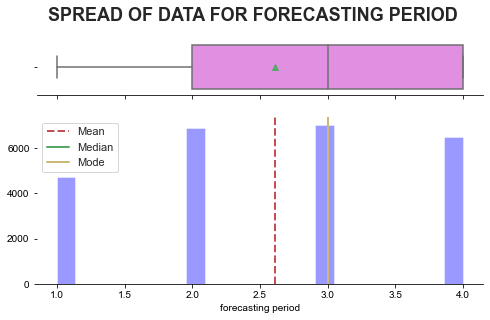

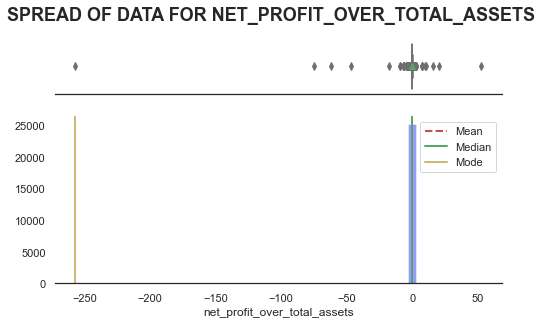

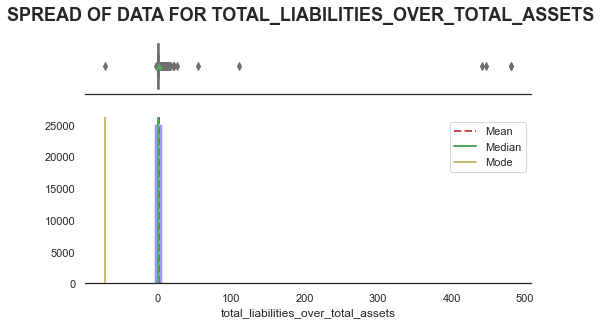

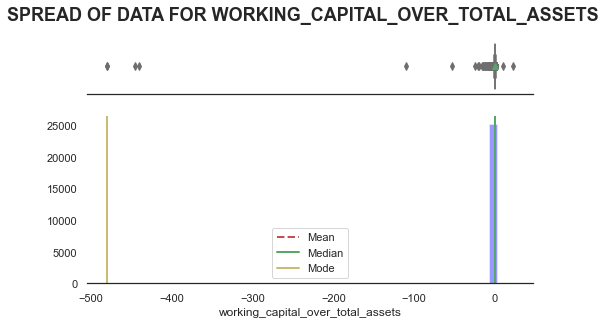

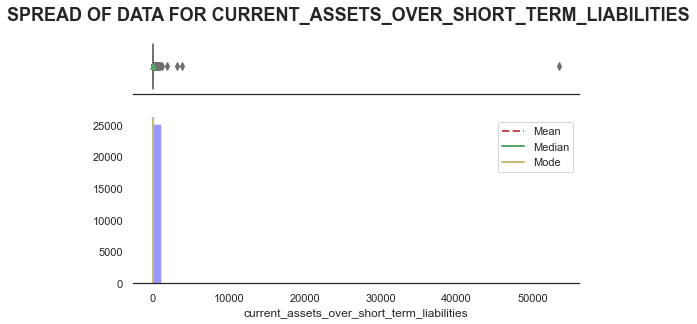

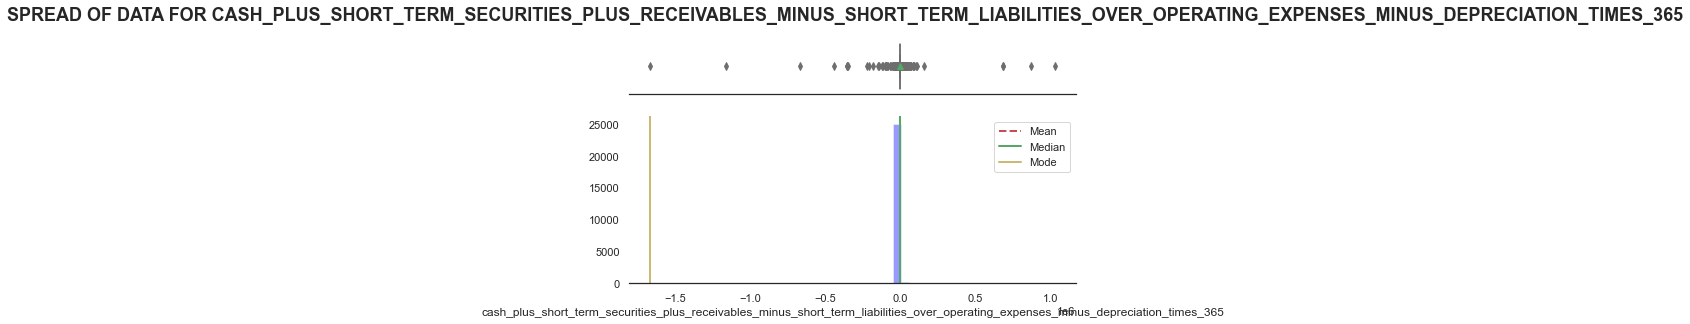

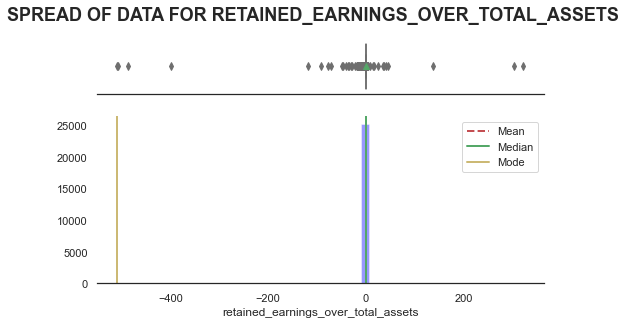

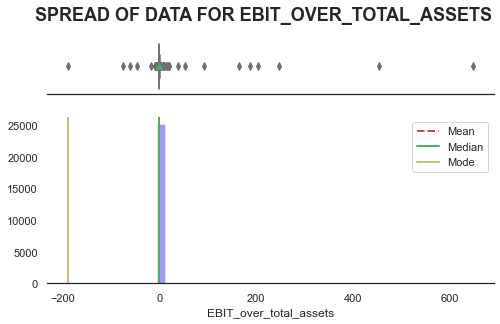

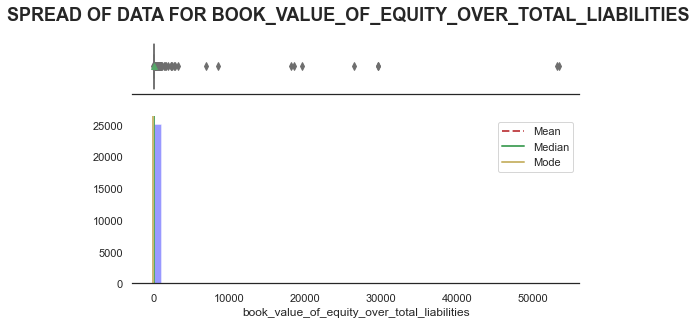

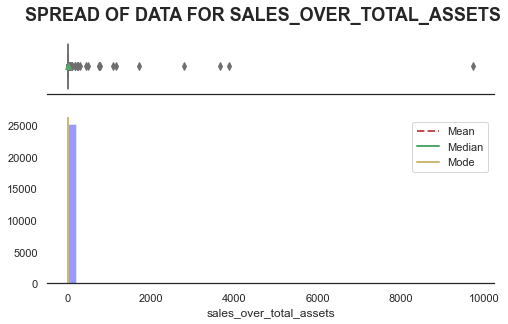

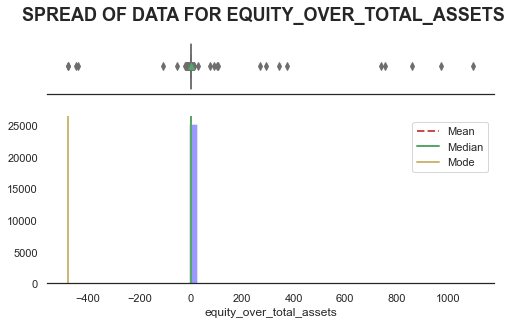

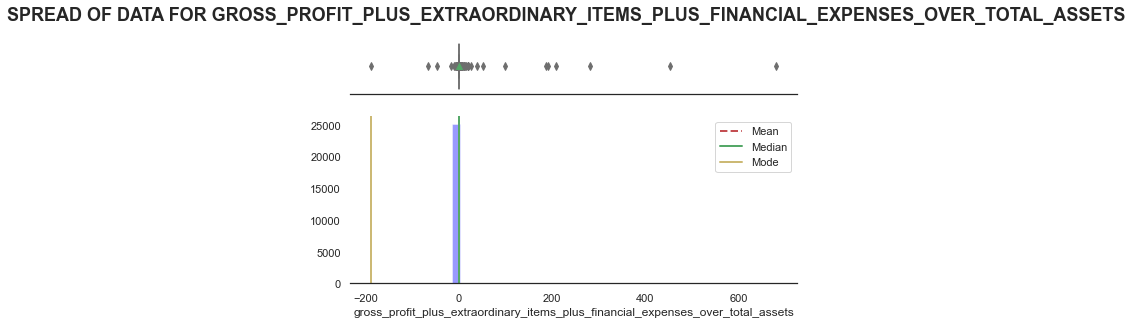

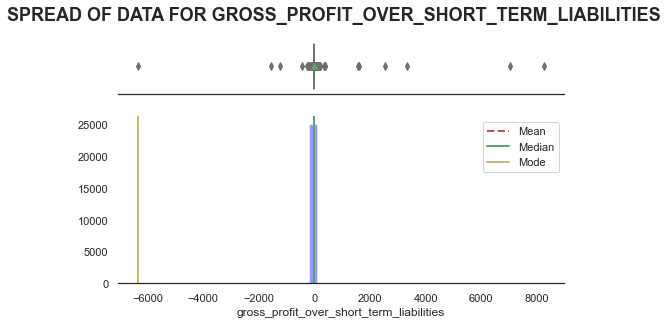

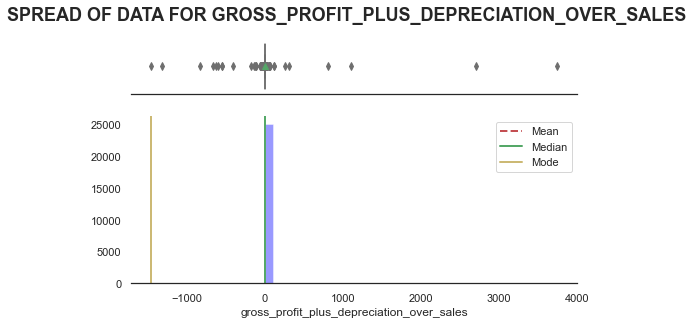

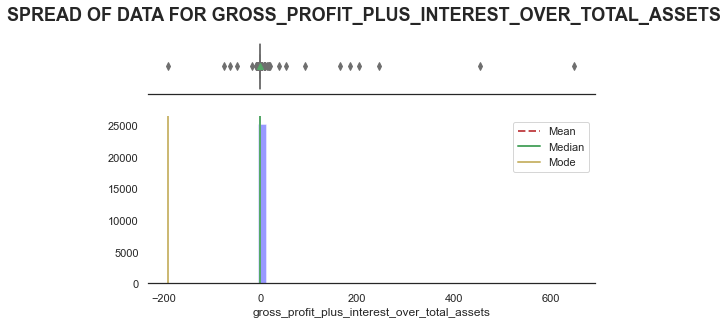

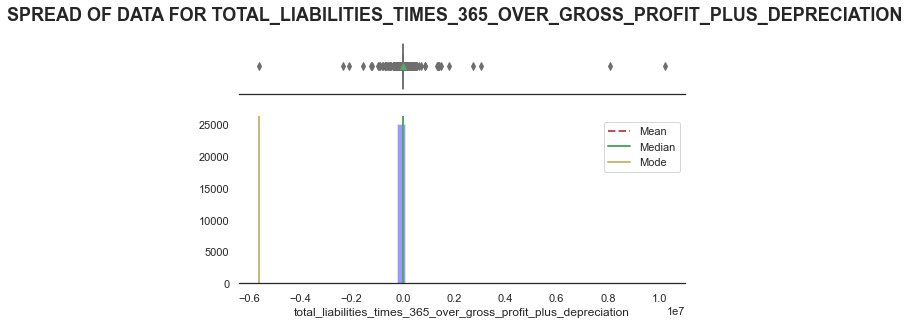

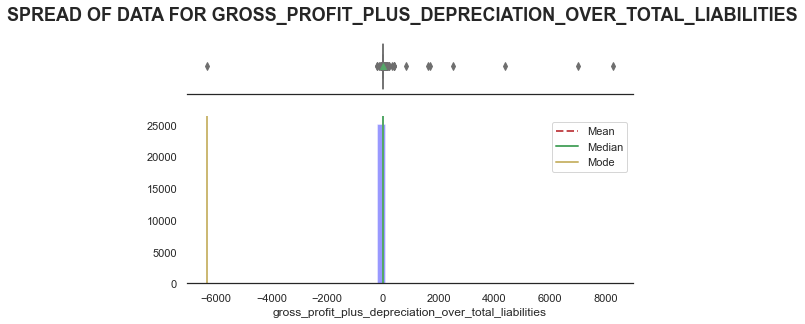

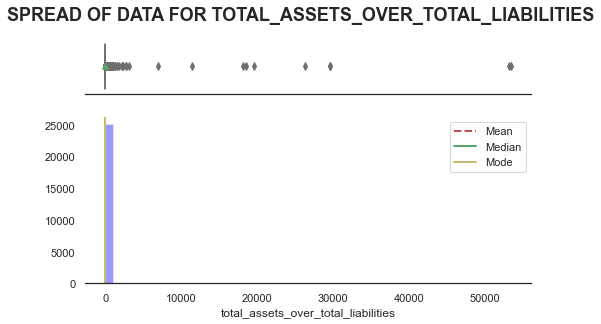

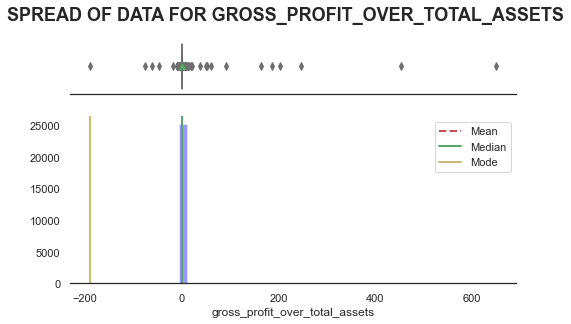

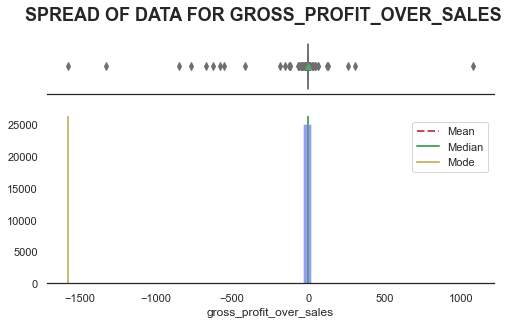

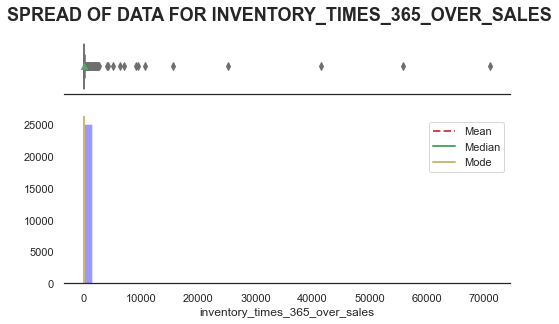

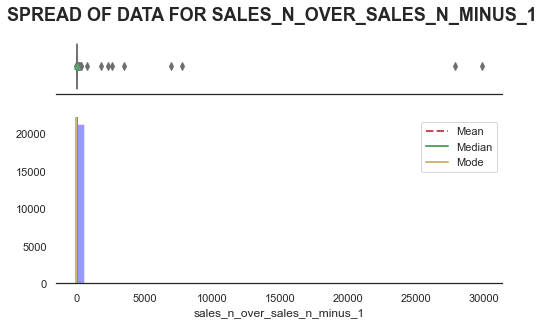

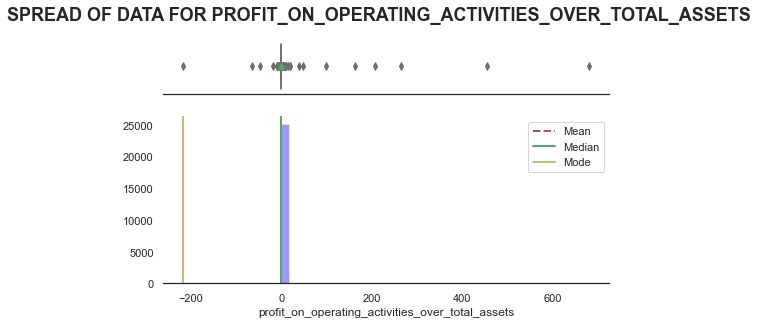

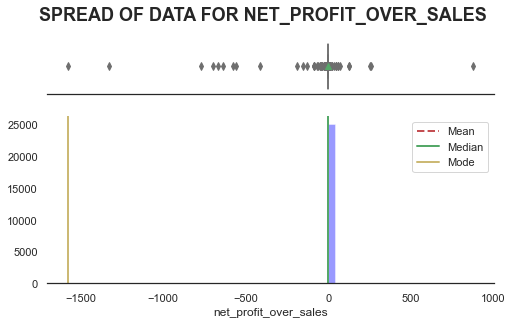

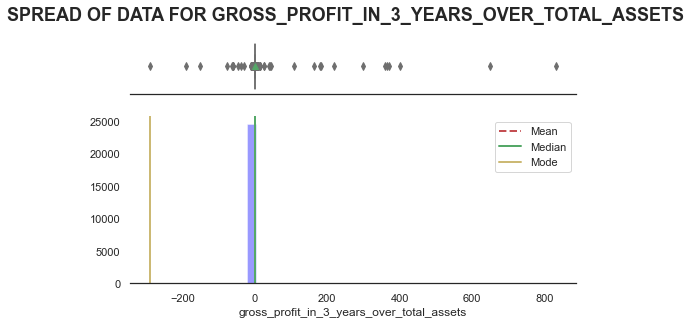

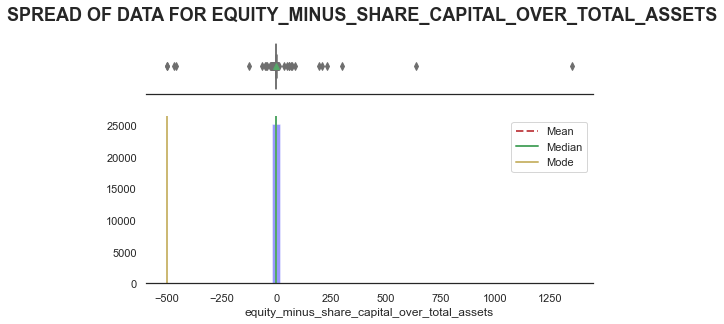

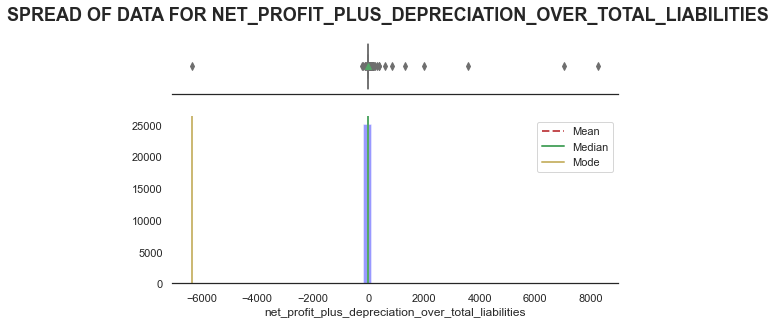

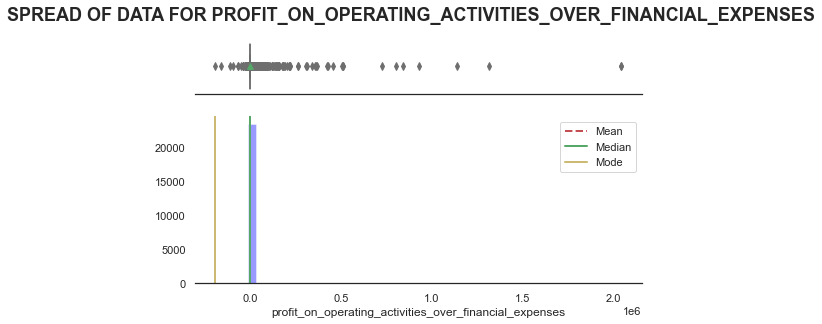

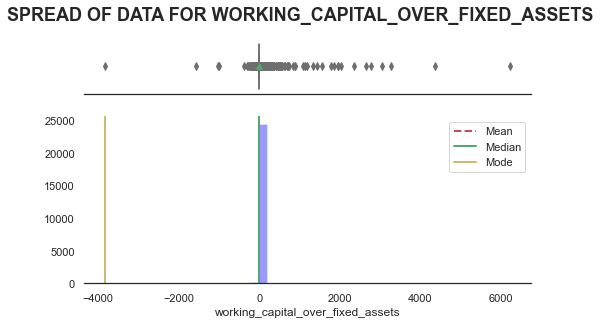

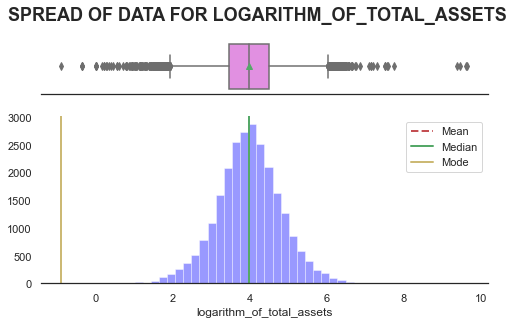

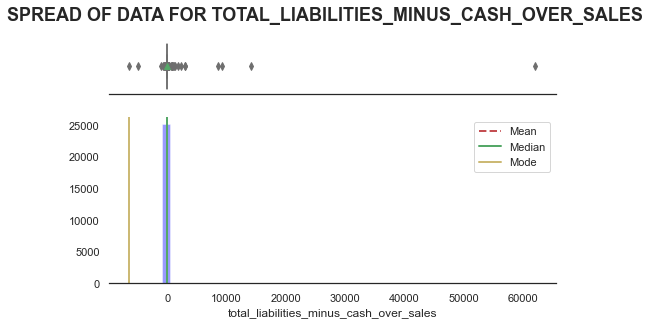

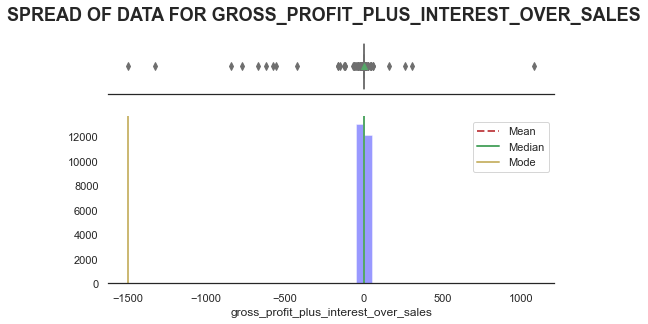

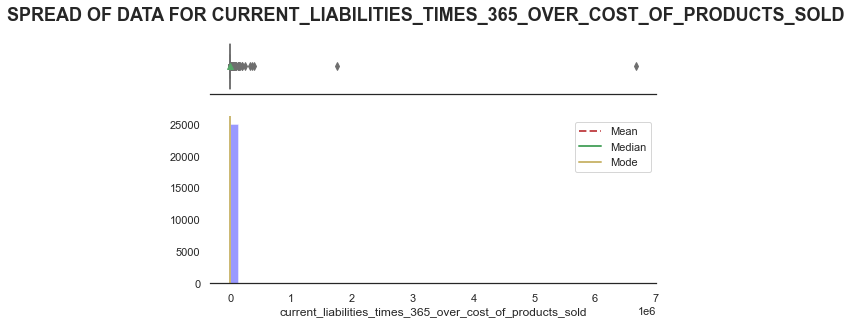

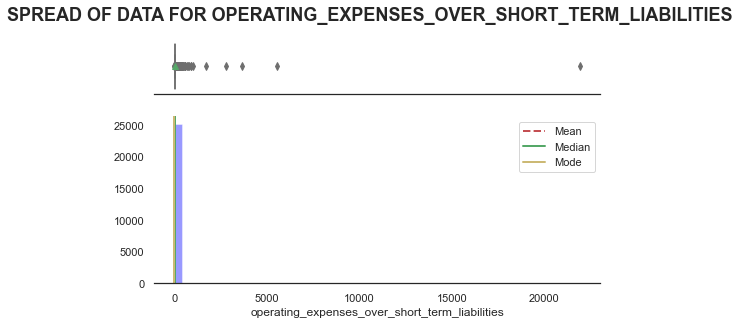

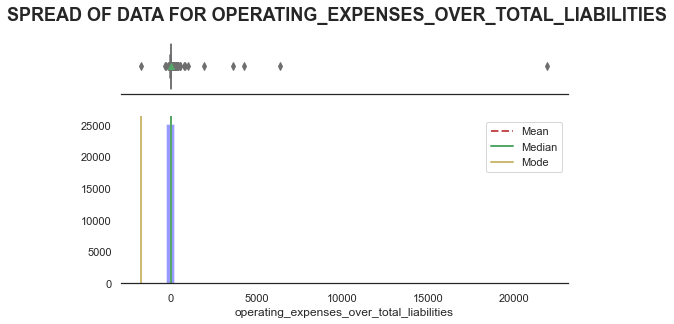

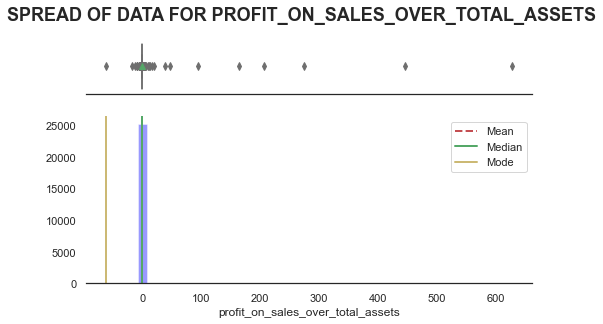

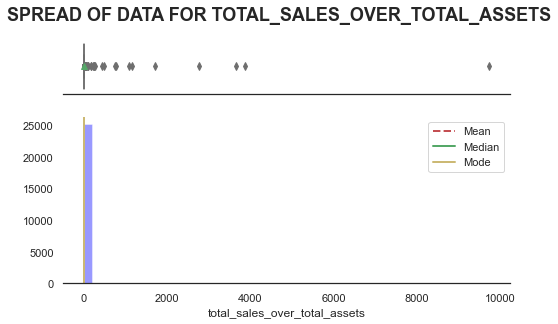

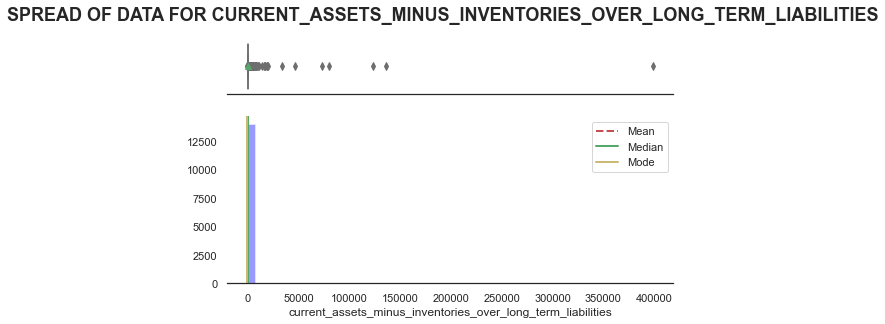

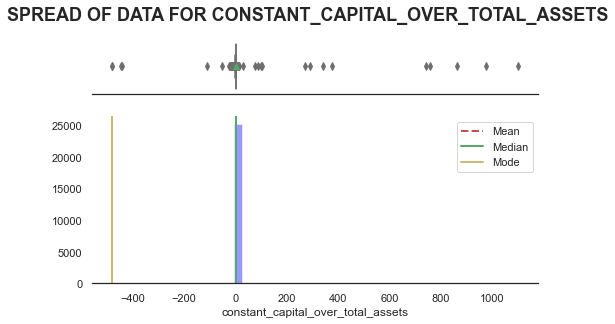

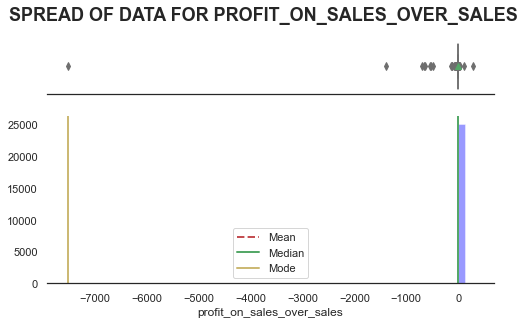

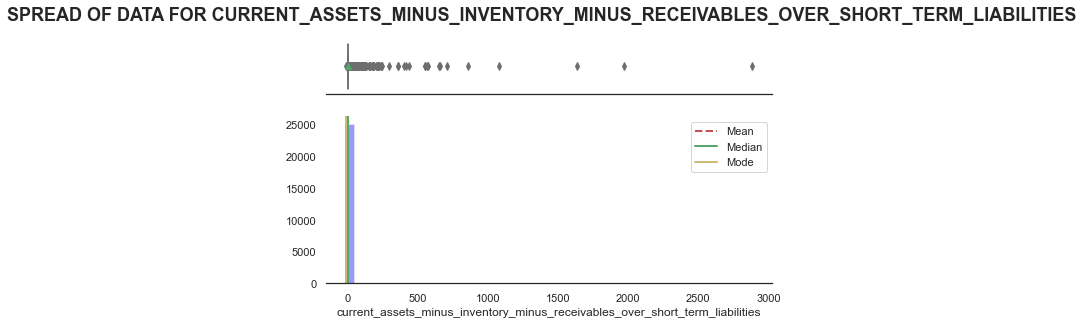

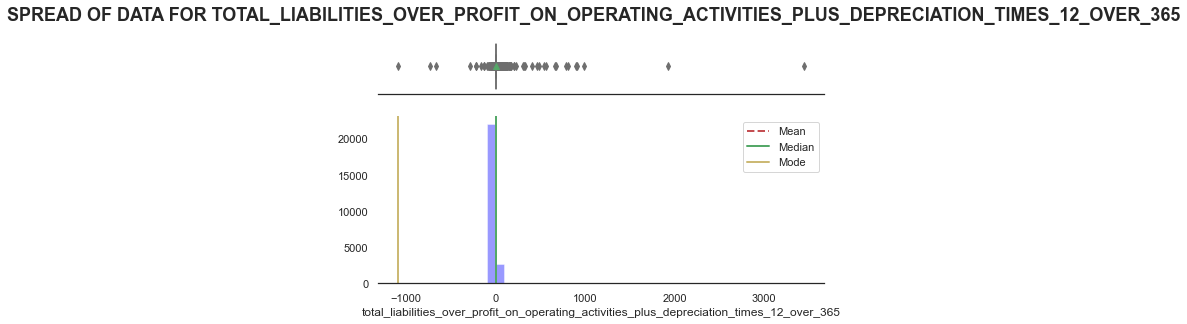

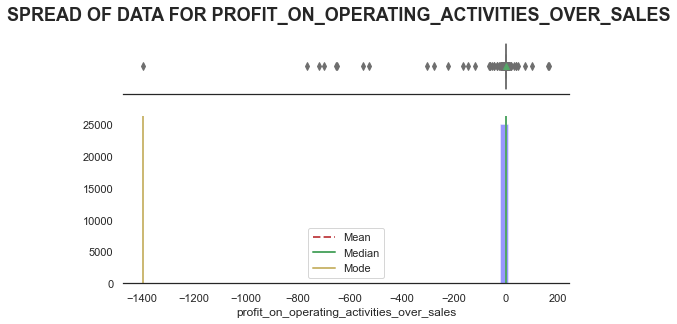

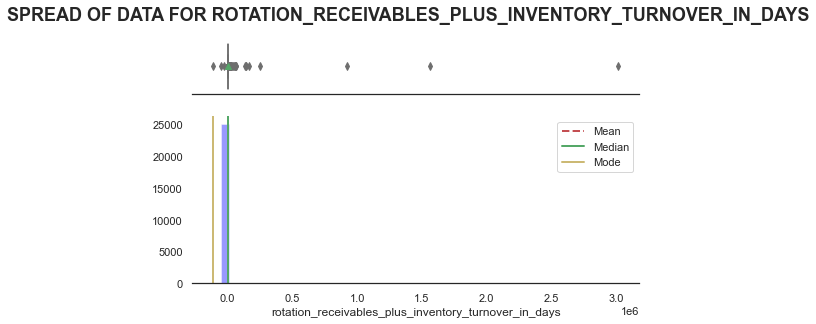

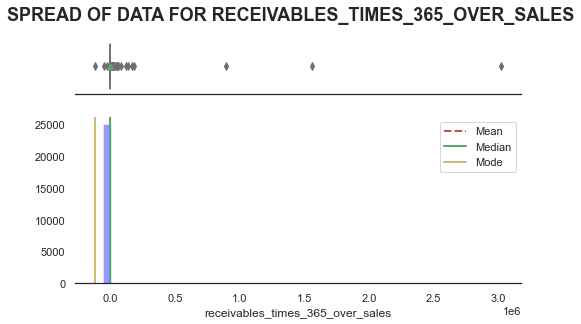

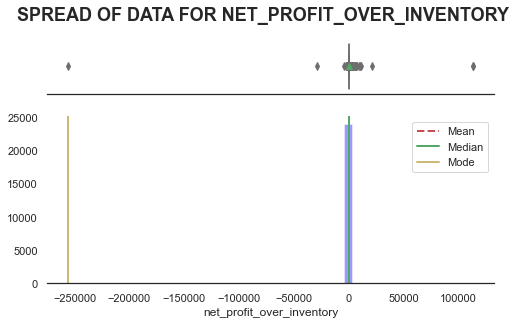

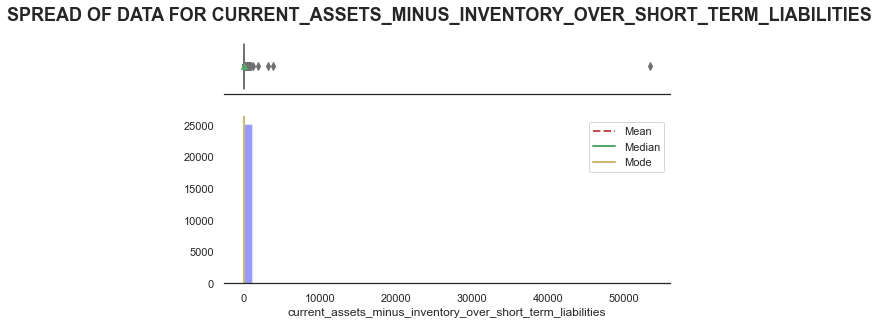

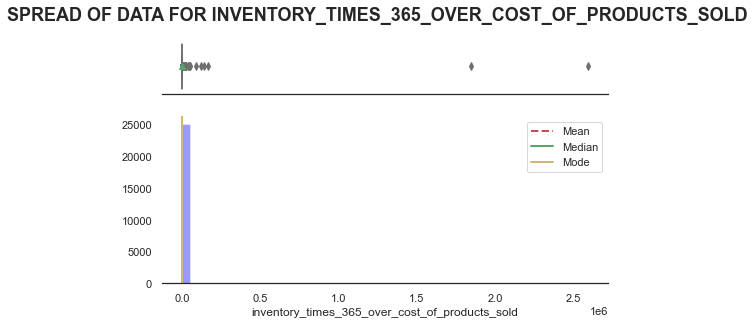

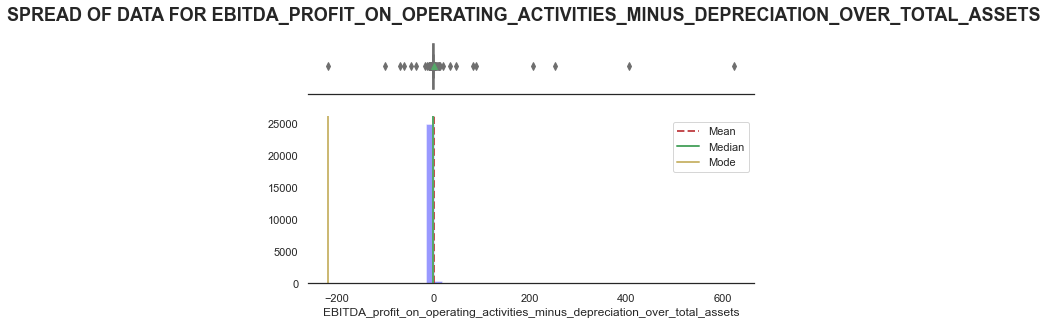

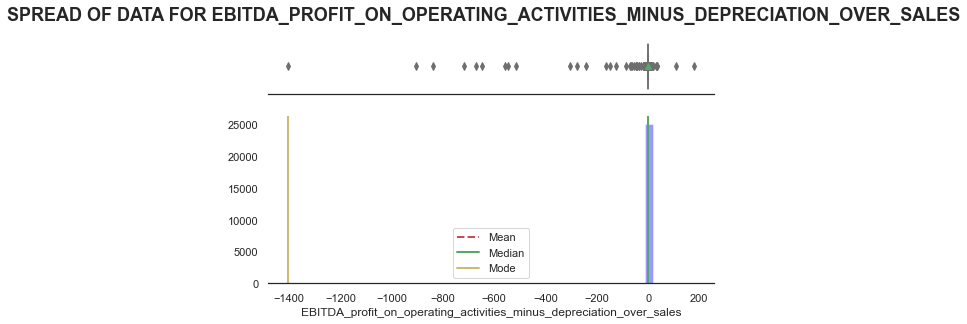

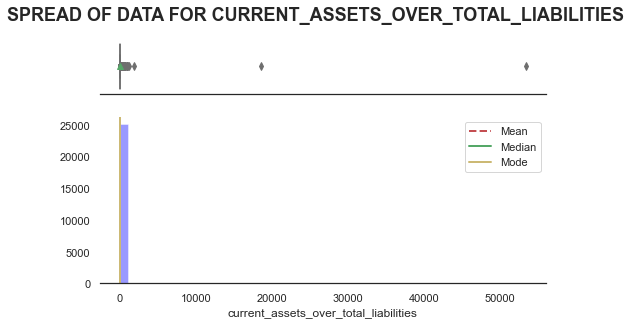

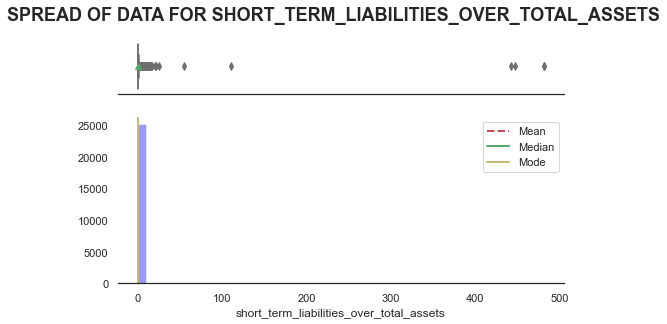

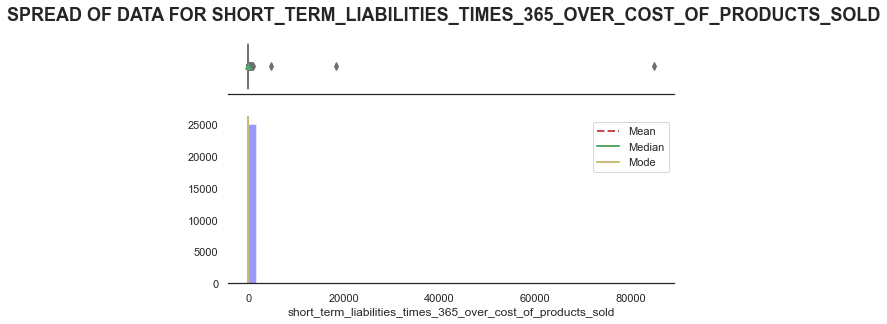

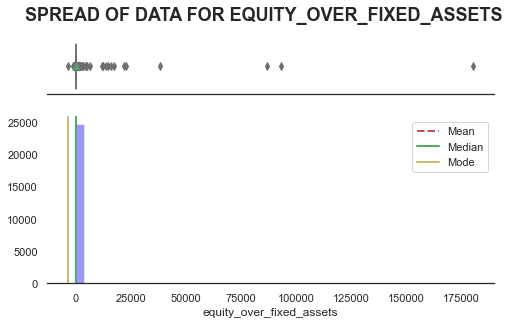

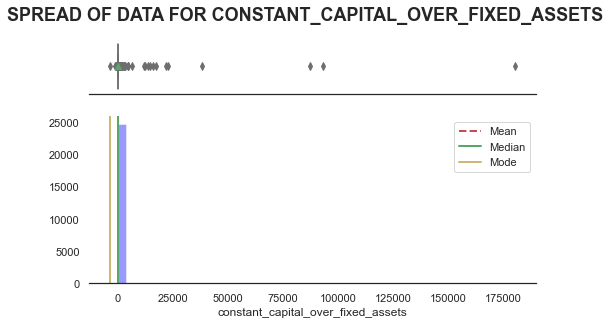

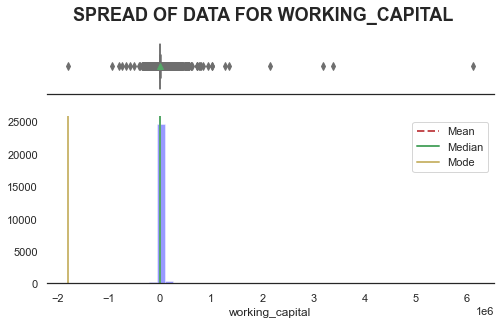

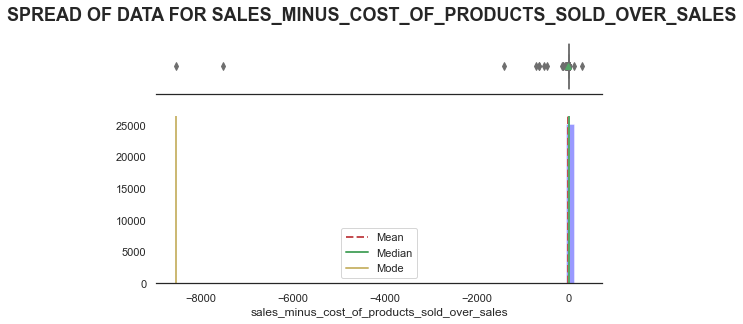

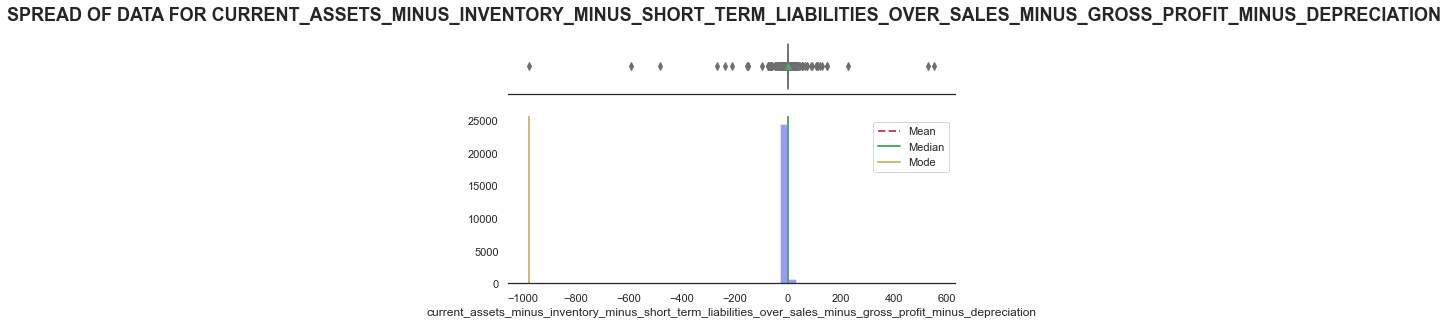

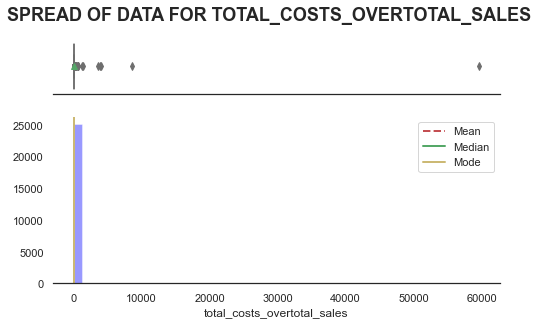

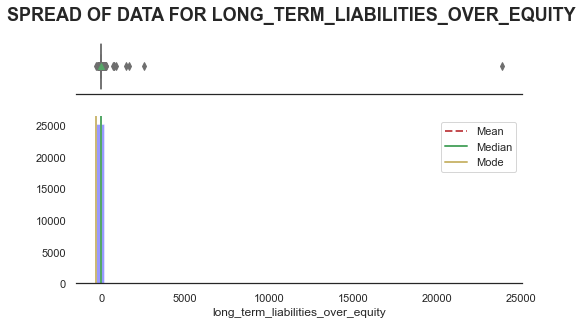

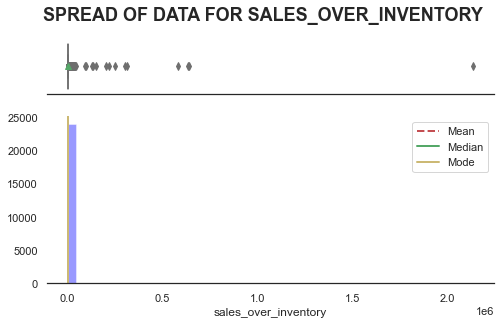

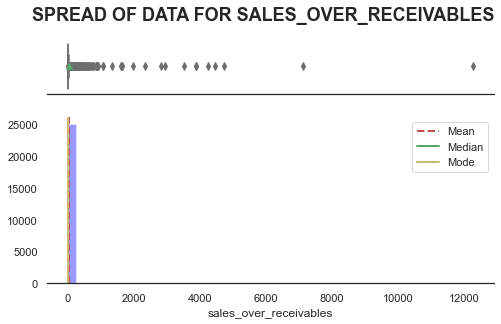

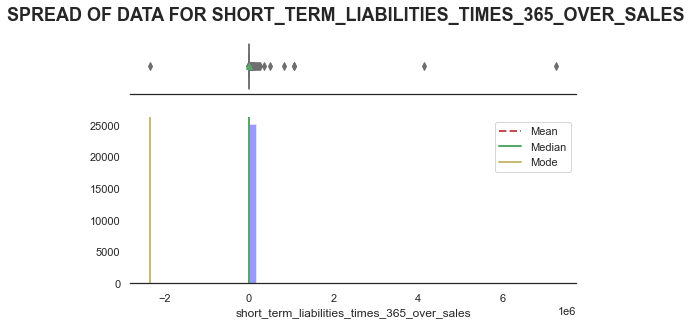

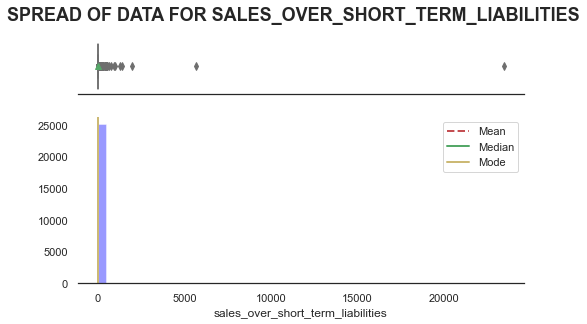

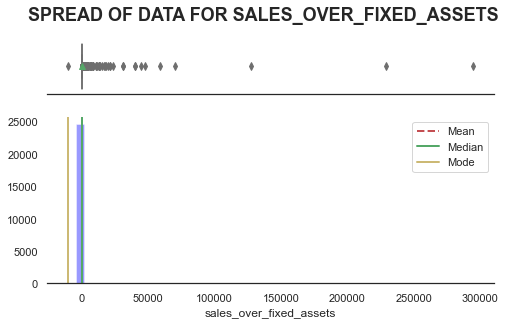

In [13]:
list_col = df.loc[:, df.columns != 'TARGET'].columns.tolist()
for i in range(len(list_col)):
    dist_box(df[list_col[i]])

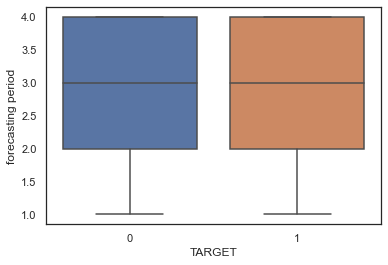

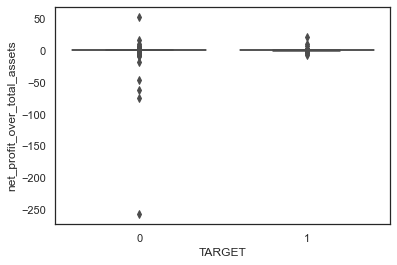

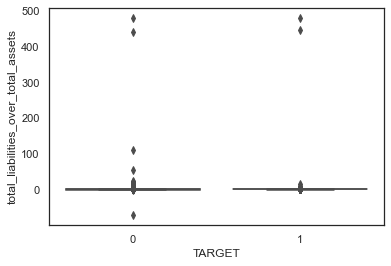

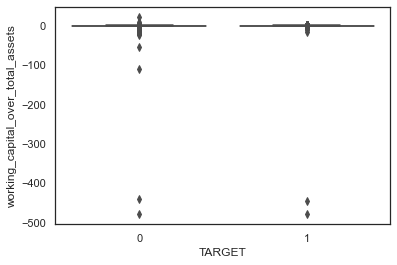

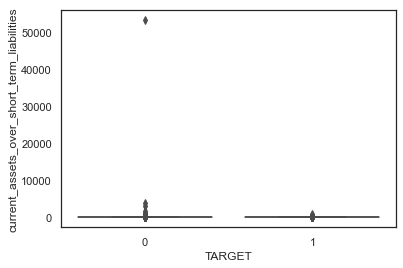

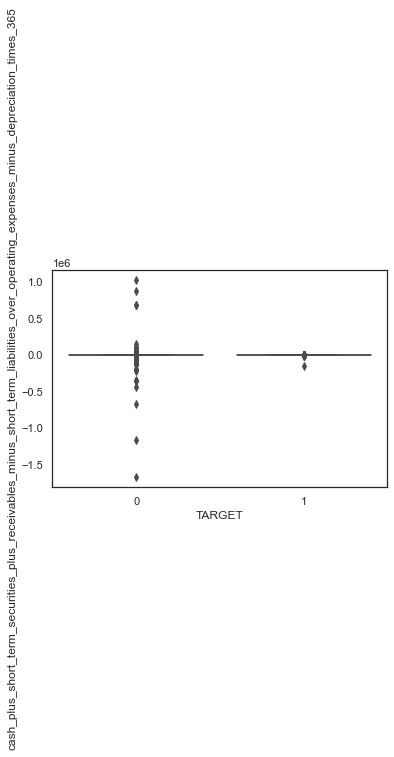

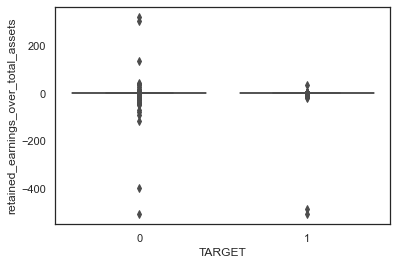

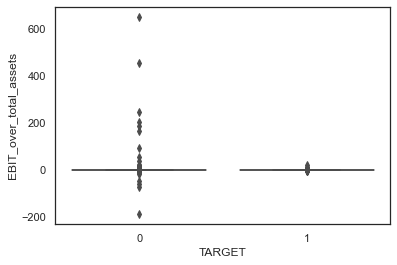

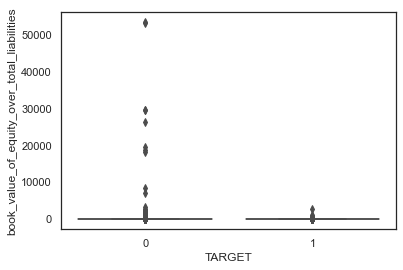

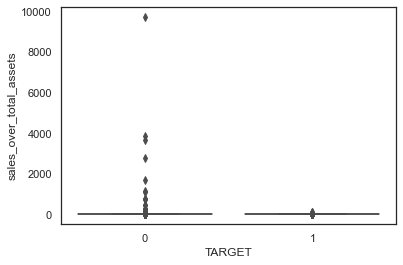

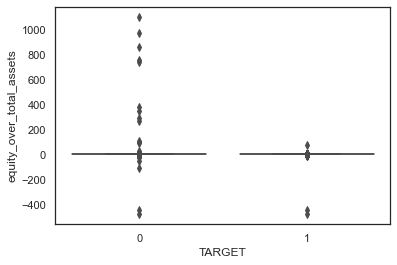

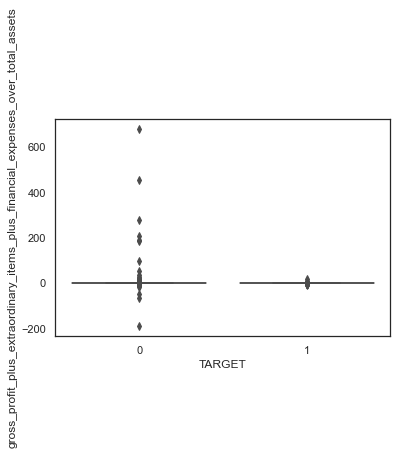

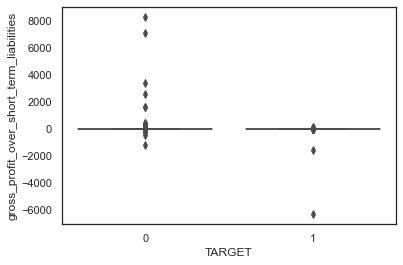

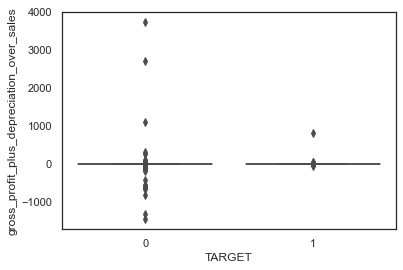

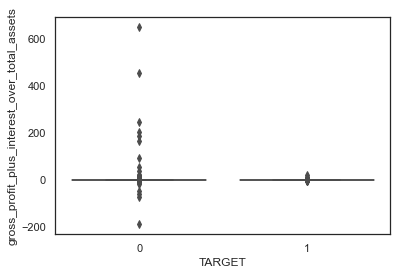

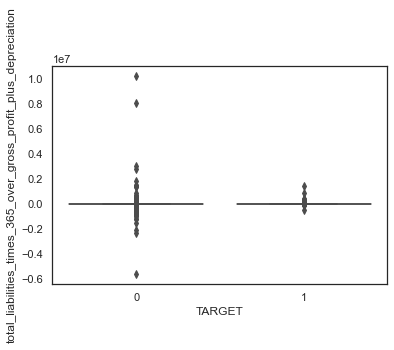

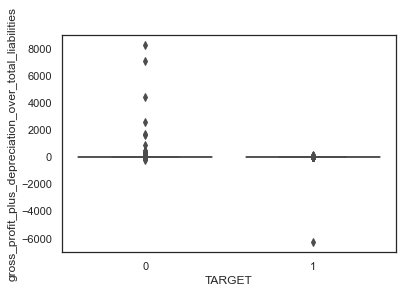

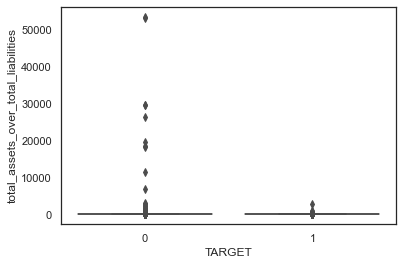

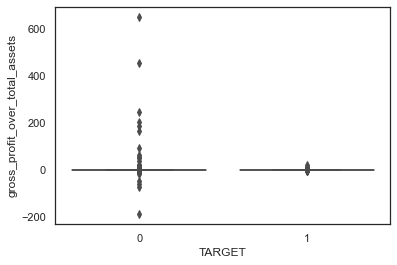

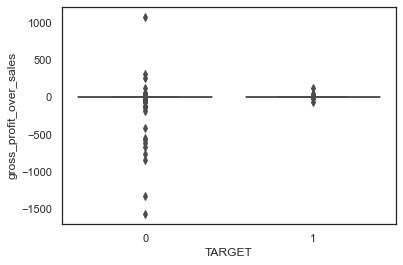

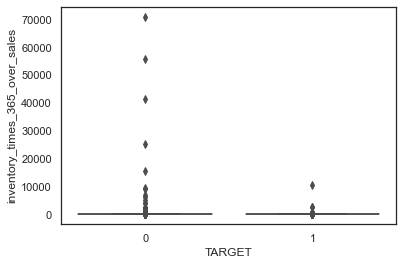

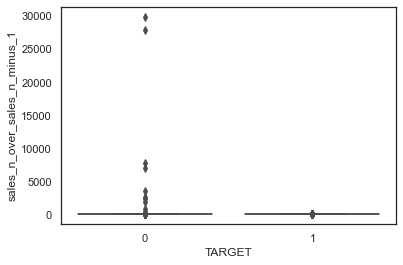

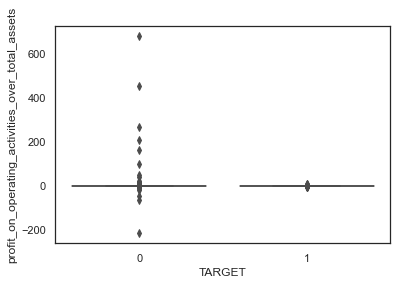

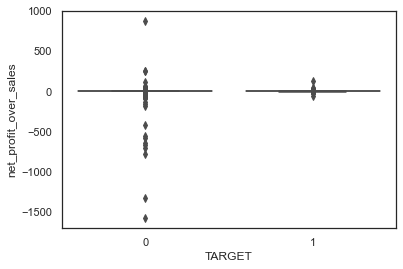

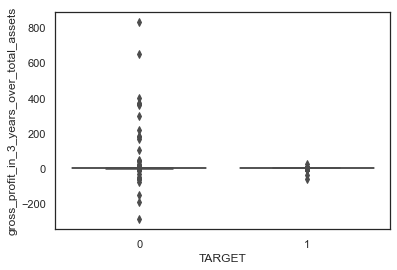

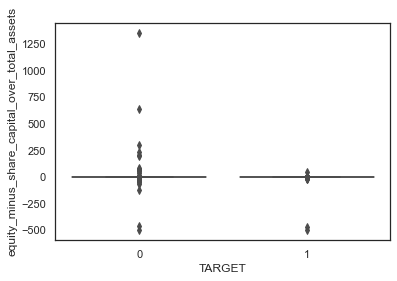

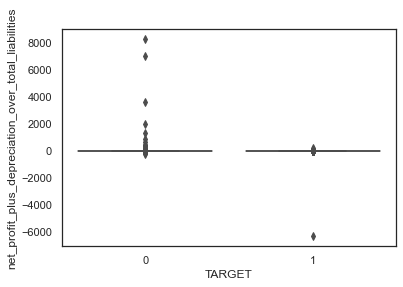

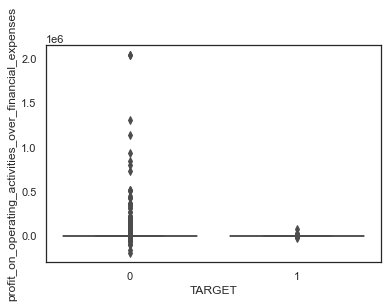

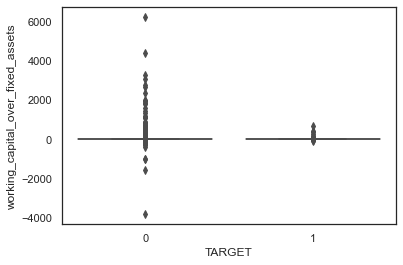

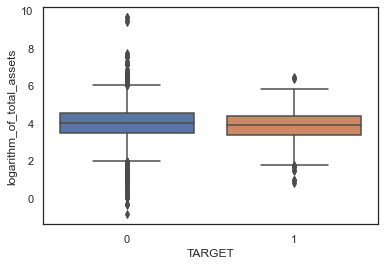

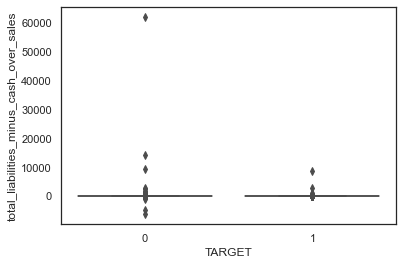

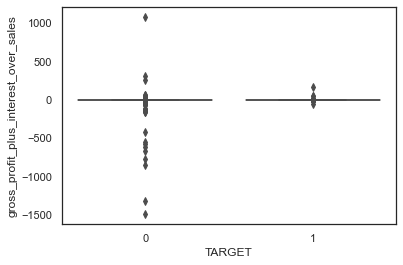

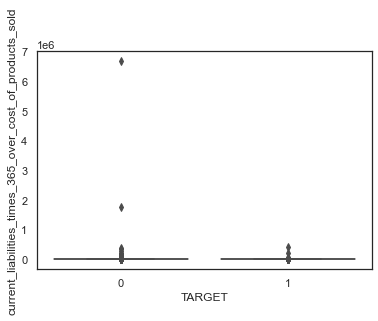

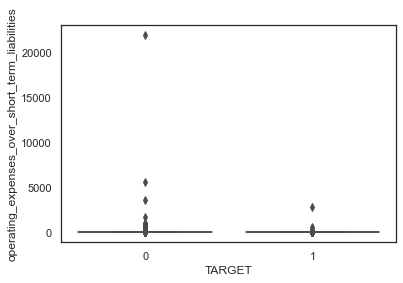

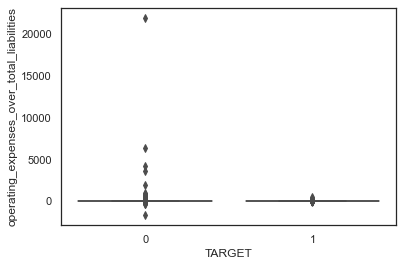

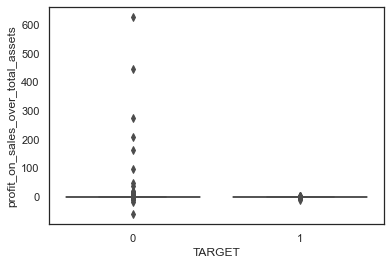

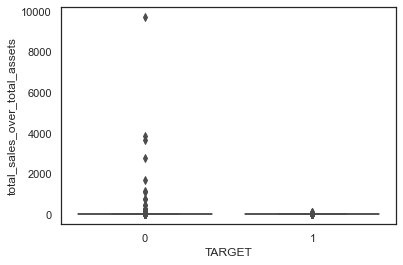

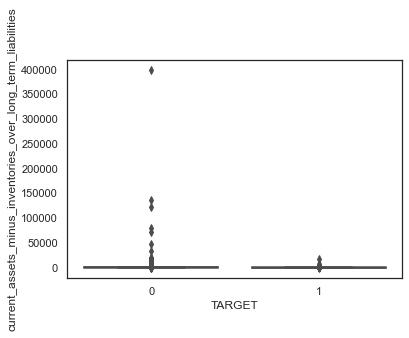

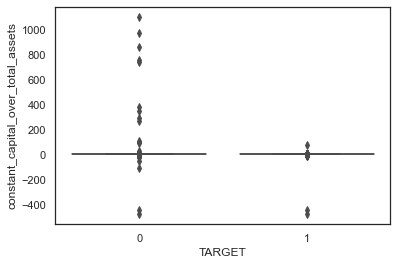

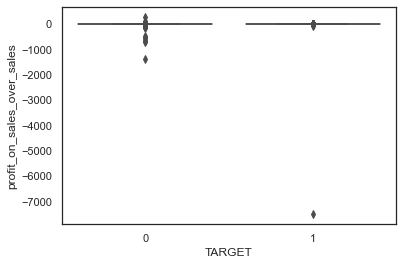

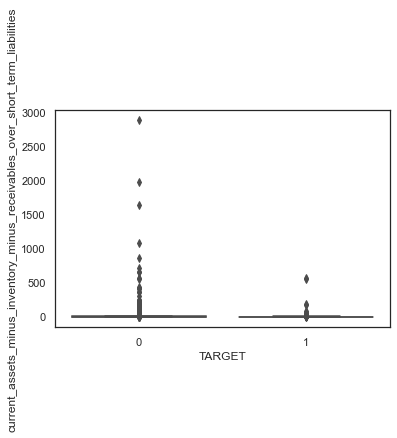

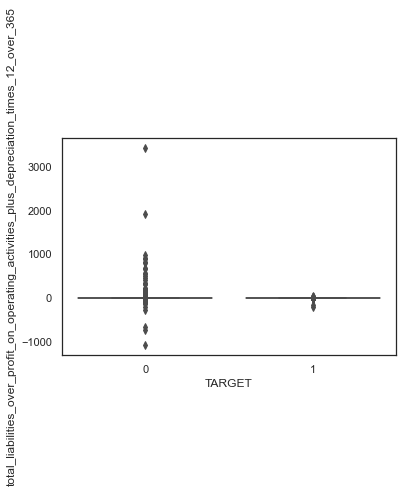

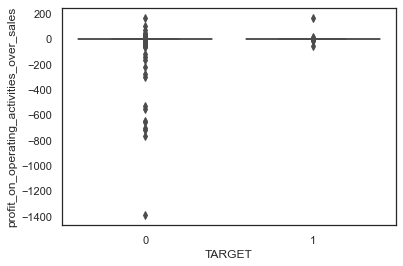

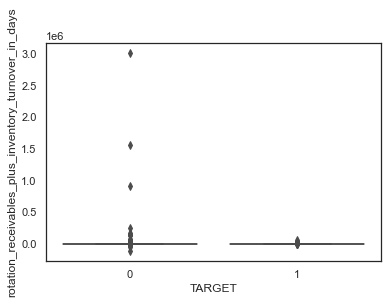

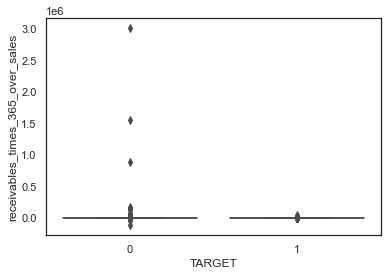

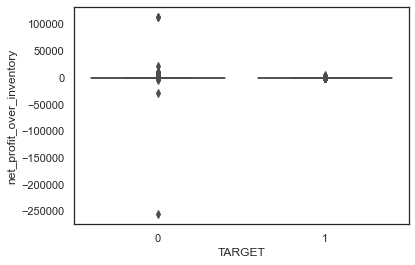

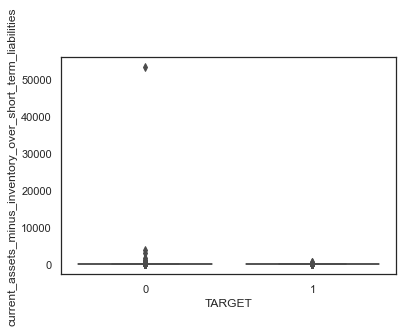

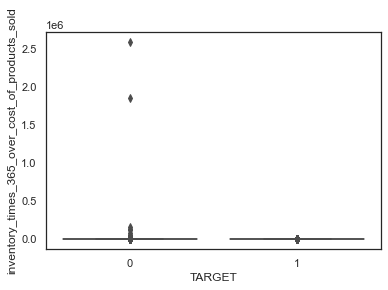

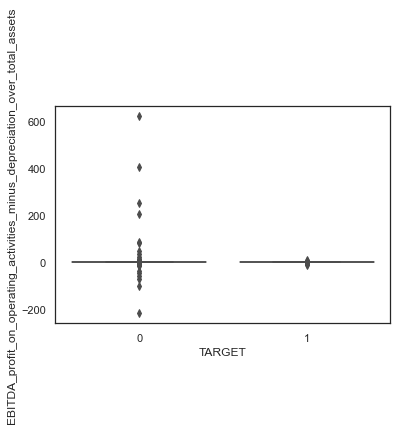

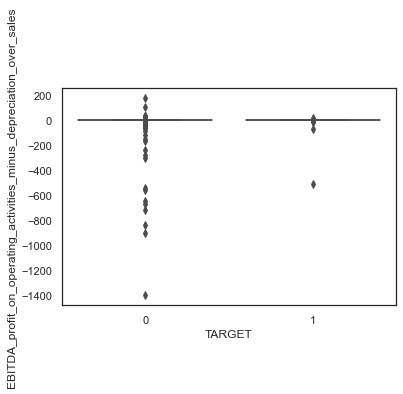

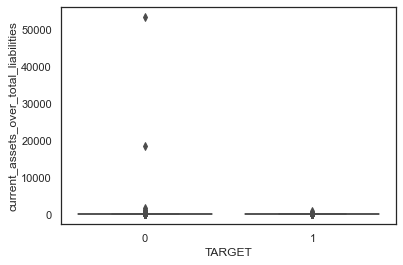

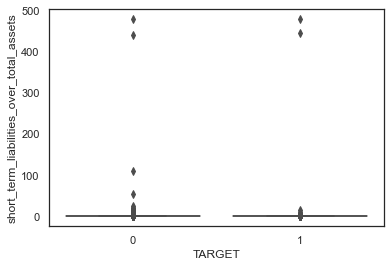

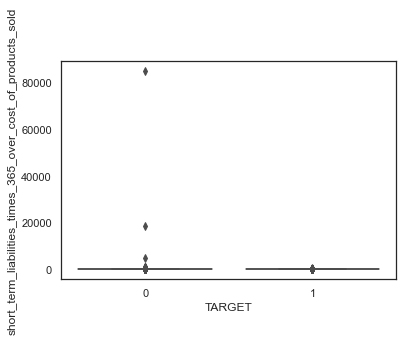

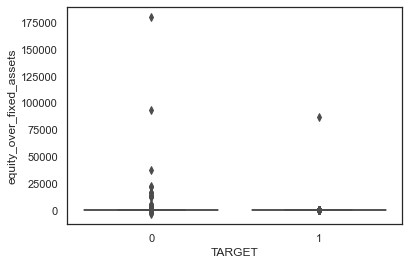

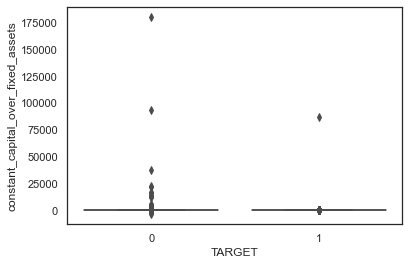

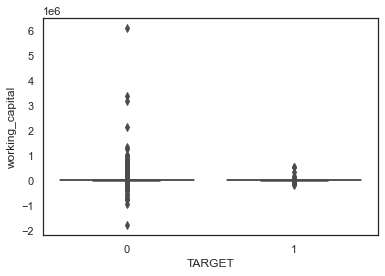

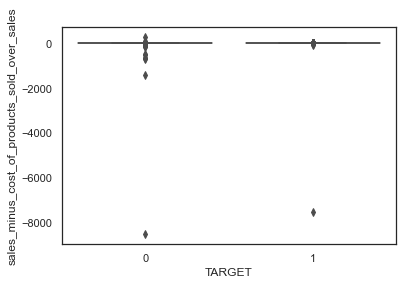

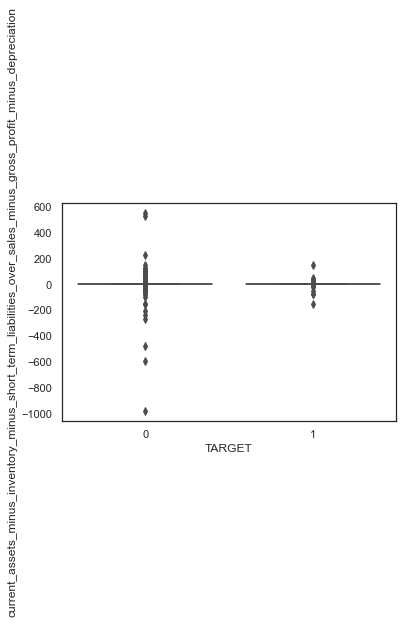

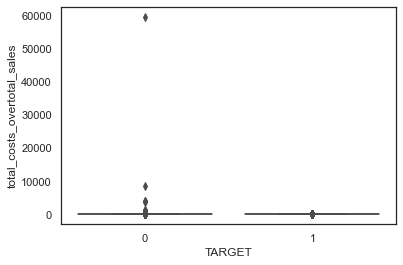

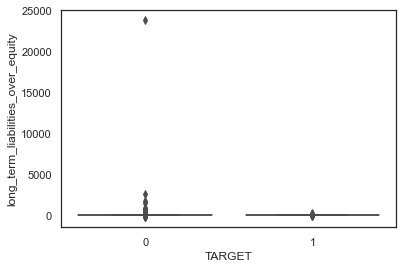

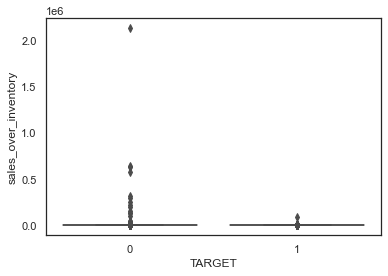

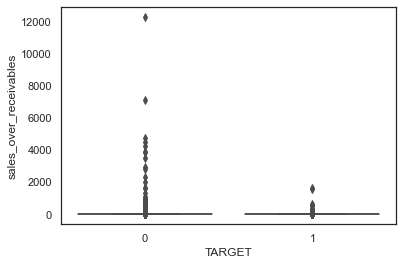

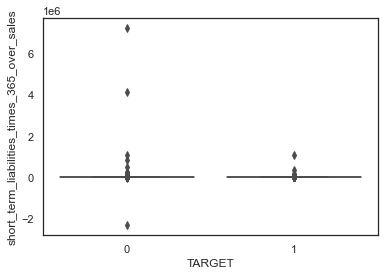

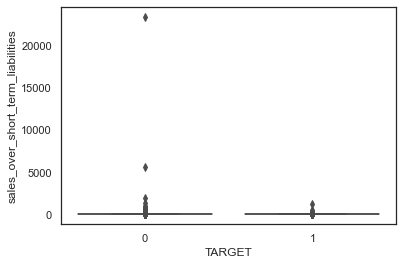

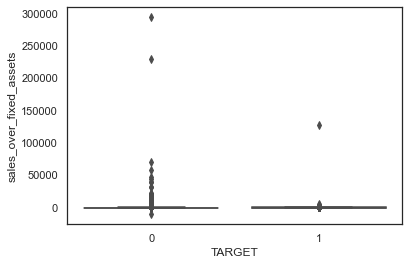

In [14]:
for col in list_col:
    plt.figure()
    sns.boxplot(x='TARGET',y= df[col], data=df)

**There are so many outliers seen in the graphs. We need to tackle this problem to get models function properly.** 

# Impute missing values

In [15]:
for i, col in enumerate(df.columns.tolist()):
    # count number of rows with missing values
    n_miss = df[[col]].isnull().sum()
    perc = n_miss / df.shape[0] * 100
    print('Feature: %d, Missing: %d (%.1f%%) of entire rows' % (i, n_miss, perc))

Feature: 0, Missing: 0 (0.0%) of entire rows
Feature: 1, Missing: 3 (0.0%) of entire rows
Feature: 2, Missing: 3 (0.0%) of entire rows
Feature: 3, Missing: 3 (0.0%) of entire rows
Feature: 4, Missing: 78 (0.3%) of entire rows
Feature: 5, Missing: 57 (0.2%) of entire rows
Feature: 6, Missing: 3 (0.0%) of entire rows
Feature: 7, Missing: 3 (0.0%) of entire rows
Feature: 8, Missing: 49 (0.2%) of entire rows
Feature: 9, Missing: 7 (0.0%) of entire rows
Feature: 10, Missing: 3 (0.0%) of entire rows
Feature: 11, Missing: 26 (0.1%) of entire rows
Feature: 12, Missing: 78 (0.3%) of entire rows
Feature: 13, Missing: 77 (0.3%) of entire rows
Feature: 14, Missing: 3 (0.0%) of entire rows
Feature: 15, Missing: 22 (0.1%) of entire rows
Feature: 16, Missing: 50 (0.2%) of entire rows
Feature: 17, Missing: 49 (0.2%) of entire rows
Feature: 18, Missing: 3 (0.0%) of entire rows
Feature: 19, Missing: 78 (0.3%) of entire rows
Feature: 20, Missing: 77 (0.3%) of entire rows
Feature: 21, Missing: 3911 (15.6%

In [16]:
df.drop(df.columns[37], axis=1, inplace=True)

In [17]:
col_names = df.columns.tolist()

In [18]:
df_1 = df.copy()

**K-Nearest Neighbor method**

In [19]:
imputer = KNNImputer(n_neighbors = 10)
df_1 = imputer.fit_transform(df_1)
df_1 = pd.DataFrame(df_1)

In [20]:
df_1.columns = col_names

In [21]:
print(df_1.isnull().sum().sum())

0


# Remove outliers

In [22]:
print(df_1.shape)

(25121, 65)


In [23]:
def outliers(df, ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 50 * IQR
    upper_bound = Q3 + 50 * IQR
    
    ls = df.index[ (df[ft] < lower_bound) | (df[ft] > upper_bound) ]
    
    return ls

In [24]:
list_col_outliers = df.drop(columns = ['TARGET', 'forecasting period'], axis = 1).columns.tolist()

In [25]:
index_list_1 = []
for feature in list_col_outliers:
    index_list_1.extend(outliers(df_1, feature))

In [26]:
index_list_1

[37,
 2150,
 8473,
 9329,
 9888,
 11913,
 12018,
 12503,
 12856,
 14018,
 14401,
 18016,
 18110,
 18944,
 19482,
 22541,
 24914,
 2150,
 9329,
 12503,
 12856,
 15122,
 18016,
 22541,
 23415,
 37,
 2150,
 9329,
 12503,
 12856,
 15469,
 18016,
 22541,
 23415,
 23724,
 227,
 299,
 642,
 702,
 852,
 1114,
 1352,
 2017,
 2035,
 2045,
 2070,
 2204,
 2486,
 2888,
 3017,
 3413,
 4376,
 4520,
 4645,
 4970,
 5156,
 5247,
 5369,
 5925,
 6092,
 6111,
 6614,
 7040,
 7146,
 7295,
 7803,
 8445,
 8857,
 9199,
 9226,
 9739,
 9749,
 10109,
 10467,
 10481,
 10596,
 10812,
 10923,
 11435,
 11468,
 12053,
 12142,
 12523,
 13121,
 13255,
 13786,
 14205,
 14277,
 14639,
 15121,
 15687,
 15718,
 15743,
 15749,
 15847,
 16451,
 16463,
 16678,
 16754,
 17004,
 17153,
 17365,
 17542,
 17594,
 17788,
 18110,
 18181,
 18554,
 18742,
 18942,
 19324,
 19547,
 19551,
 21229,
 21807,
 21953,
 22043,
 22148,
 22440,
 22716,
 22738,
 22789,
 23196,
 23245,
 23327,
 23440,
 23507,
 23646,
 23690,
 24059,
 24083,
 24114,


In [27]:
def remove(df, ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df

In [28]:
df_1_cleaned = remove(df_1, index_list_1)

In [29]:
df_1_cleaned.shape

(21531, 65)

In [30]:
df_1_cleaned.head()

,forecasting period,net_profit_over_total_assets,total_liabilities_over_total_assets,working_capital_over_total_assets,current_assets_over_short_term_liabilities,cash_plus_short_term_securities_plus_receivables_minus_short_term_liabilities_over_operating_expenses_minus_depreciation_times_365,retained_earnings_over_total_assets,EBIT_over_total_assets,book_value_of_equity_over_total_liabilities,sales_over_total_assets,equity_over_total_assets,gross_profit_plus_extraordinary_items_plus_financial_expenses_over_total_assets,gross_profit_over_short_term_liabilities,gross_profit_plus_depreciation_over_sales,gross_profit_plus_interest_over_total_assets,total_liabilities_times_365_over_gross_profit_plus_depreciation,gross_profit_plus_depreciation_over_total_liabilities,total_assets_over_total_liabilities,gross_profit_over_total_assets,gross_profit_over_sales,inventory_times_365_over_sales,sales_n_over_sales_n_minus_1,profit_on_operating_activities_over_total_assets,net_profit_over_sales,gross_profit_in_3_years_over_total_assets,equity_minus_share_capital_over_total_assets,net_profit_plus_depreciation_over_total_liabilities,profit_on_operating_activities_over_financial_expenses,working_capital_over_fixed_assets,logarithm_of_total_assets,total_liabilities_minus_cash_over_sales,gross_profit_plus_interest_over_sales,current_liabilities_times_365_over_cost_of_products_sold,operating_expenses_over_short_term_liabilities,operating_expenses_over_total_liabilities,profit_on_sales_over_total_assets,total_sales_over_total_assets,constant_capital_over_total_assets,profit_on_sales_over_sales,current_assets_minus_inventory_minus_receivables_over_short_term_liabilities,total_liabilities_over_profit_on_operating_activities_plus_depreciation_times_12_over_365,profit_on_operating_activities_over_sales,rotation_receivables_plus_inventory_turnover_in_days,receivables_times_365_over_sales,net_profit_over_inventory,current_assets_minus_inventory_over_short_term_liabilities,inventory_times_365_over_cost_of_products_sold,EBITDA_profit_on_operating_activities_minus_depreciation_over_total_assets,EBITDA_profit_on_operating_activities_minus_depreciation_over_sales,current_assets_over_total_liabilities,short_term_liabilities_over_total_assets,short_term_liabilities_times_365_over_cost_of_products_sold,equity_over_fixed_assets,constant_capital_over_fixed_assets,working_capital,sales_minus_cost_of_products_sold_over_sales,current_assets_minus_inventory_minus_short_term_liabilities_over_sales_minus_gross_profit_minus_depreciation,total_costs_overtotal_sales,long_term_liabilities_over_equity,sales_over_inventory,sales_over_receivables,short_term_liabilities_times_365_over_sales,sales_over_short_term_liabilities,sales_over_fixed_assets,TARGET
0,4.0,0.141939,0.450292,0.021422,1.052987,-28.529084,0.141934,0.172629,0.990337,1.087356,0.445948,0.172640,0.428585,0.098482,0.172624,737.598361,0.495022,2.220462,0.172637,0.076198,28.299285,1.028425,0.189883,0.062675,0.172627,0.445979,0.426729,8.316441,0.037083,4.572500,0.192113,0.076140,70.555409,5.173971,0.421745,0.189890,2.290576,0.493565,0.083730,0.057484,0.059290,0.083765,64.960411,36.353133,0.809085,0.617367,30.730599,0.139658,0.061639,0.941651,0.402678,0.191955,0.775922,0.856486,800.542408,0.079572,0.318286,0.927687,0.106818,12.941797,10.044585,64.713700,5.626894,3.937064,1.0
1,4.0,0.147560,0.234840,0.708335,4.016018,119.445611,0.457090,0.186070,3.206445,1.093404,0.753147,0.186074,0.792274,0.086800,0.186064,427.990535,0.852970,4.257781,0.186070,0.080696,1.542870,1.051072,0.184396,0.064051,0.576977,0.753142,0.688729,0.839642,12.468188,4.531600,0.062277,0.080741,40.797208,8.975368,0.785422,0.184388,2.314396,0.753163,0.079966,0.402727,0.039096,0.079992,134.243197,132.943558,14.937221,3.974228,1.685798,0.170146,0.073831,4.015088,0.234846,0.111752,13.260175,13.256659,24093.000493,0.095218,0.195943,0.907056,-0.000029,233.301688,2.747416,36.967435,9.813419,40.567739,0.0
2,1.0,-0.024542,0.311544,0.067831,1.255247,-15.019923,-0.65

In [31]:
## Defining X and Y variables
X = df_1_cleaned.drop(['TARGET'], axis=1) #dropping the dependent variable
Y = df_1_cleaned[['TARGET']]

In [32]:
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X,Y)

In [33]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size = 0.3, random_state = 0)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [35]:
print(X_train_sm.shape)
print(X_train.shape)
print(X_test_sm.shape)
print(X_test.shape)

(28845, 64)
(15071, 64)
(12363, 64)
(6460, 64)


In [36]:
print(y_train_sm.shape)
print(y_train.shape)
print(y_test_sm.shape)
print(y_test.shape)

(28845, 1)
(15071, 1)
(12363, 1)
(6460, 1)


# Model Deployment

In [37]:
def scores(model):
    """ model : classifier to predict X values """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print("Accuracy on training set : ",metrics.accuracy_score(y_train,y_pred_train))
    print("Accuracy on test set : ",metrics.accuracy_score(y_test,y_pred_test))

    print("\nRecall on training set : ",metrics.recall_score(y_train,y_pred_train))
    print("Recall on test set : ",metrics.recall_score(y_test,y_pred_test))
    
    print("\nPrecision on training set : ",metrics.precision_score(y_train,y_pred_train))
    print("Precision on test set : ",metrics.precision_score(y_test,y_pred_test))
    
    print("\nF1 on training set : ",metrics.f1_score(y_train,y_pred_train))
    print("F1 on test set : ",metrics.f1_score(y_test,y_pred_test))

In [38]:
# Parameters are set arbitrarily. We can conduct hyperparameter tuning to improve the performance of Decision Tree model.
Dt = DecisionTreeClassifier(criterion='gini', splitter = 'best', min_samples_leaf = 5, random_state=29)
Dt.fit(X_train_sm,y_train_sm)
y_predict_Dt = Dt.predict(X_test)

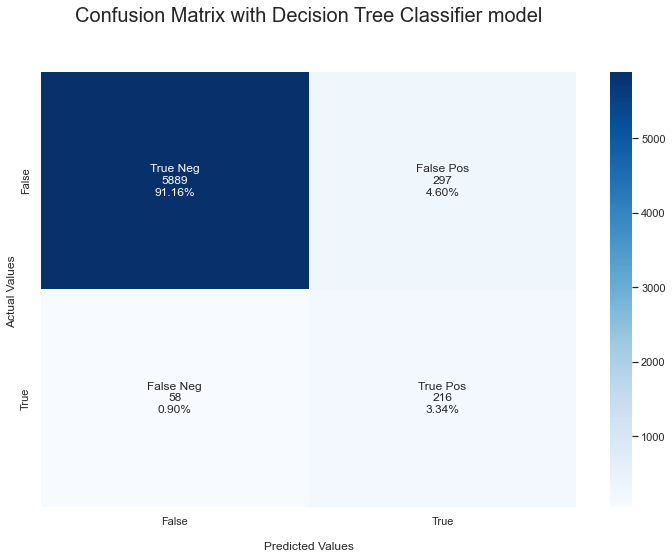

In [39]:
cf_matrix = confusion_matrix(y_test, y_predict_Dt)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with Decision Tree Classifier model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [40]:
scores(Dt)

Accuracy on training set :  0.9526905978369054
Accuracy on test set :  0.945046439628483

Recall on training set :  0.7687595712098009
Recall on test set :  0.7883211678832117

Precision on training set :  0.4718045112781955
Precision on test set :  0.42105263157894735

F1 on training set :  0.5847408270238788
F1 on test set :  0.5489199491740788


In [41]:
metrics.roc_auc_score(y_test, y_predict_Dt)

0.8701547643489773

In [42]:
rf = RandomForestClassifier(max_depth= 15, max_features= 20, min_samples_split = 5, n_estimators = 100, random_state=29)
rf.fit(X_train_sm, y_train_sm)
y_predict_Rf = rf.predict(X_test)

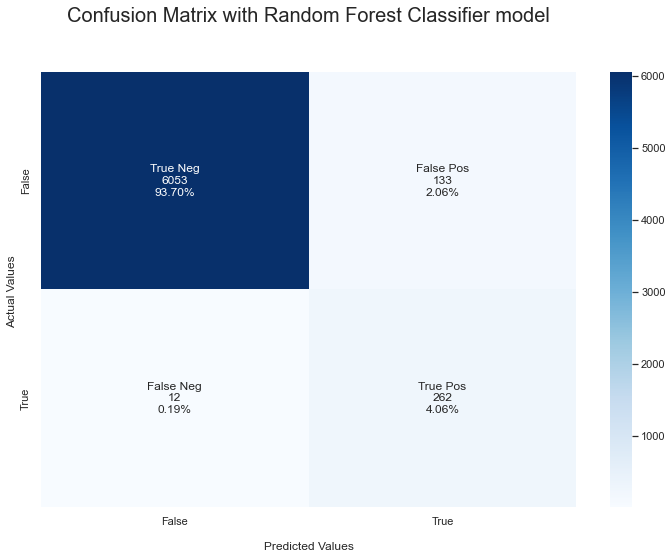

In [43]:
cf_matrix = confusion_matrix(y_test, y_predict_Rf)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with Random Forest Classifier model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [44]:
scores(rf)

Accuracy on training set :  0.9818857408267534
Accuracy on test set :  0.9775541795665634

Recall on training set :  0.9617151607963247
Recall on test set :  0.9562043795620438

Precision on training set :  0.7168949771689498
Precision on test set :  0.6632911392405063

F1 on training set :  0.8214519293655985
F1 on test set :  0.7832585949177877


In [45]:
metrics.roc_auc_score(y_test, y_predict_Rf)

0.9673521089533466

**The model performance has improved considerably with Random Forest .** 

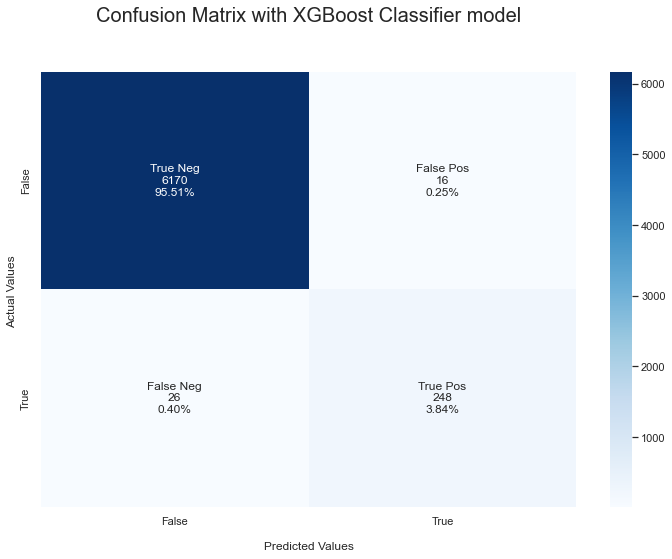

In [46]:
xgb_model = XGBClassifier(base_score= 0.5, booster= 'gbtree', 
                                learning_rate= 0.1, n_estimators= 500, random_state=29)
xgb_model.fit(X_train_sm, y_train_sm)

y_pre_xgb = xgb_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pre_xgb)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with XGBoost Classifier model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [47]:
scores(xgb_model)

Accuracy on training set :  0.9962179019308606
Accuracy on test set :  0.9934984520123838

Recall on training set :  0.9433384379785605
Recall on test set :  0.9051094890510949

Precision on training set :  0.9685534591194969
Precision on test set :  0.9393939393939394

F1 on training set :  0.9557796741660203
F1 on test set :  0.9219330855018588


In [48]:
metrics.roc_auc_score(y_test, y_pre_xgb)

0.9512615017192105

# We can see that Random Forest Classifier and XGBoost Classifier give much more accurate predictions compared to other models.

# To improve Random Forest and XGBoost Classifiers, we can carry on hyperparameter tuning to find the most optimal model.

In [49]:
clf_rf_tuned = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [5, 10], 
    'n_estimators' : [100, 300, 500],
    'max_depth': [5, 15, 25],
}
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [50]:
def grid_search_wrapper(refit_score='accuracy_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=3)
    grid_search = GridSearchCV(clf_rf_tuned, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train_sm.values, y_train_sm.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [51]:
before_grid_time = datetime.datetime.now()

In [52]:
grid_search_clf = grid_search_wrapper(refit_score='accuracy_score')
after_grid_time = datetime.datetime.now()

Best params for accuracy_score
{'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for accuracy_score on the test data:
     pred_neg  pred_pos
neg      6108        78
pos         2       272


In [53]:
time_grid = after_grid_time - before_grid_time
print('It took :', time_grid, 'to find optimal model')

It took : 0:13:52.742438 to find optimal model


# Deploy Random Forest Classifier model with best parameters tuned

In [54]:
rf_t = RandomForestClassifier(max_depth= 25, min_samples_split = 5, n_estimators = 500, random_state=29)
rf_t.fit(X_train_sm, y_train_sm)
y_predict_Rf_tuned = rf_t.predict(X_test)

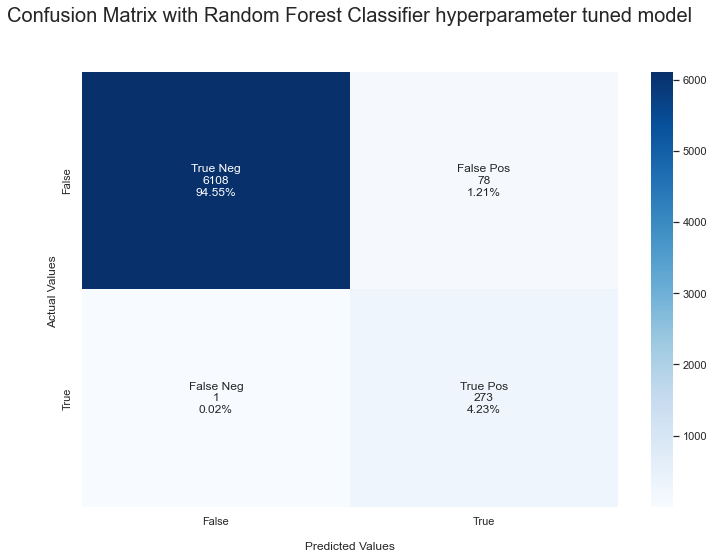

In [55]:
cf_matrix = confusion_matrix(y_test, y_predict_Rf_tuned)
plt.figure(figsize=(12,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with Random Forest Classifier hyperparameter tuned model\n\n',fontsize=20);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [56]:
scores(rf_t)

Accuracy on training set :  0.9925021564594254
Accuracy on test set :  0.9877708978328174

Recall on training set :  0.9877488514548239
Recall on test set :  0.9963503649635036

Precision on training set :  0.86
Precision on test set :  0.7777777777777778

F1 on training set :  0.9194583036350676
F1 on test set :  0.8736


In [57]:
metrics.roc_auc_score(y_test, y_predict_Rf_tuned)

0.9918706238008593

# Deploy XGBoost Classifier model with best parameters tuned

In [58]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'base_score': [0.2, 0.5, 1]
}

gs2 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), 
                   scoring='accuracy')
gs2.fit(X_train_sm, y_train_sm)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)

Best score: 0.9877621771537529
Best score: {'base_score': 0.2, 'booster': 'gbtree', 'learning_rate': 0.1, 'n_estimators': 500}


**We found that the initial parameters we set for XGBoost Classifier model was already best parameters for optimal accuracy score.**

# ROC_AUC CURVE

In [59]:
fpr1, tpr1, _ = metrics.roc_curve(y_test, y_predict_Rf_tuned)
fpr2, tpr2, _ = metrics.roc_curve(y_test, y_pre_xgb)

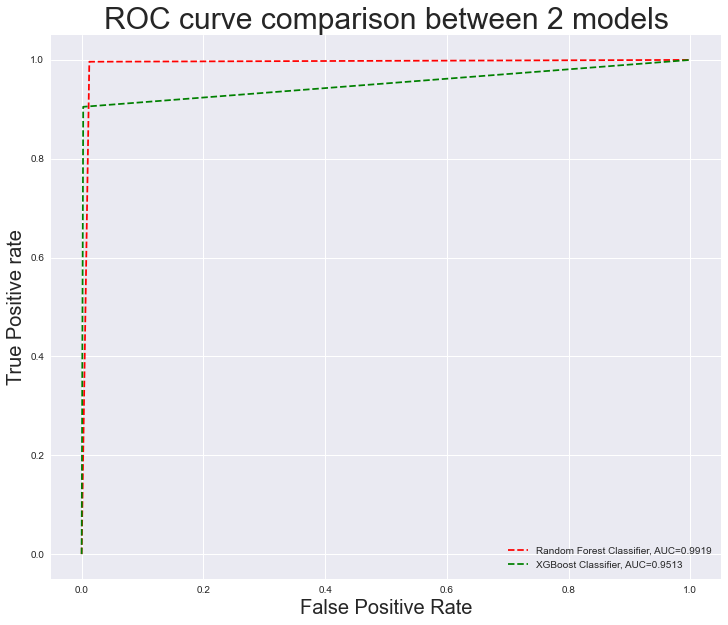

In [60]:
plt.style.use('seaborn')
plt.figure(0, figsize = (12,10)).clf()
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='Random Forest Classifier, AUC='+str(round(metrics.roc_auc_score(y_test, y_predict_Rf_tuned), 4)))
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='XGBoost Classifier, AUC='+str(round(metrics.roc_auc_score(y_test, y_pre_xgb), 4)))
plt.title('ROC curve comparison between 2 models', fontsize = 30)
# x label
plt.xlabel('False Positive Rate', fontsize = 20)
# y label
plt.ylabel('True Positive rate', fontsize = 20)

plt.legend(loc='best')
plt.show()

**Both models can be used to predict bankruptcy. More in-depth analysis, Random Forest Classifier is better solution due to better AUC score.**

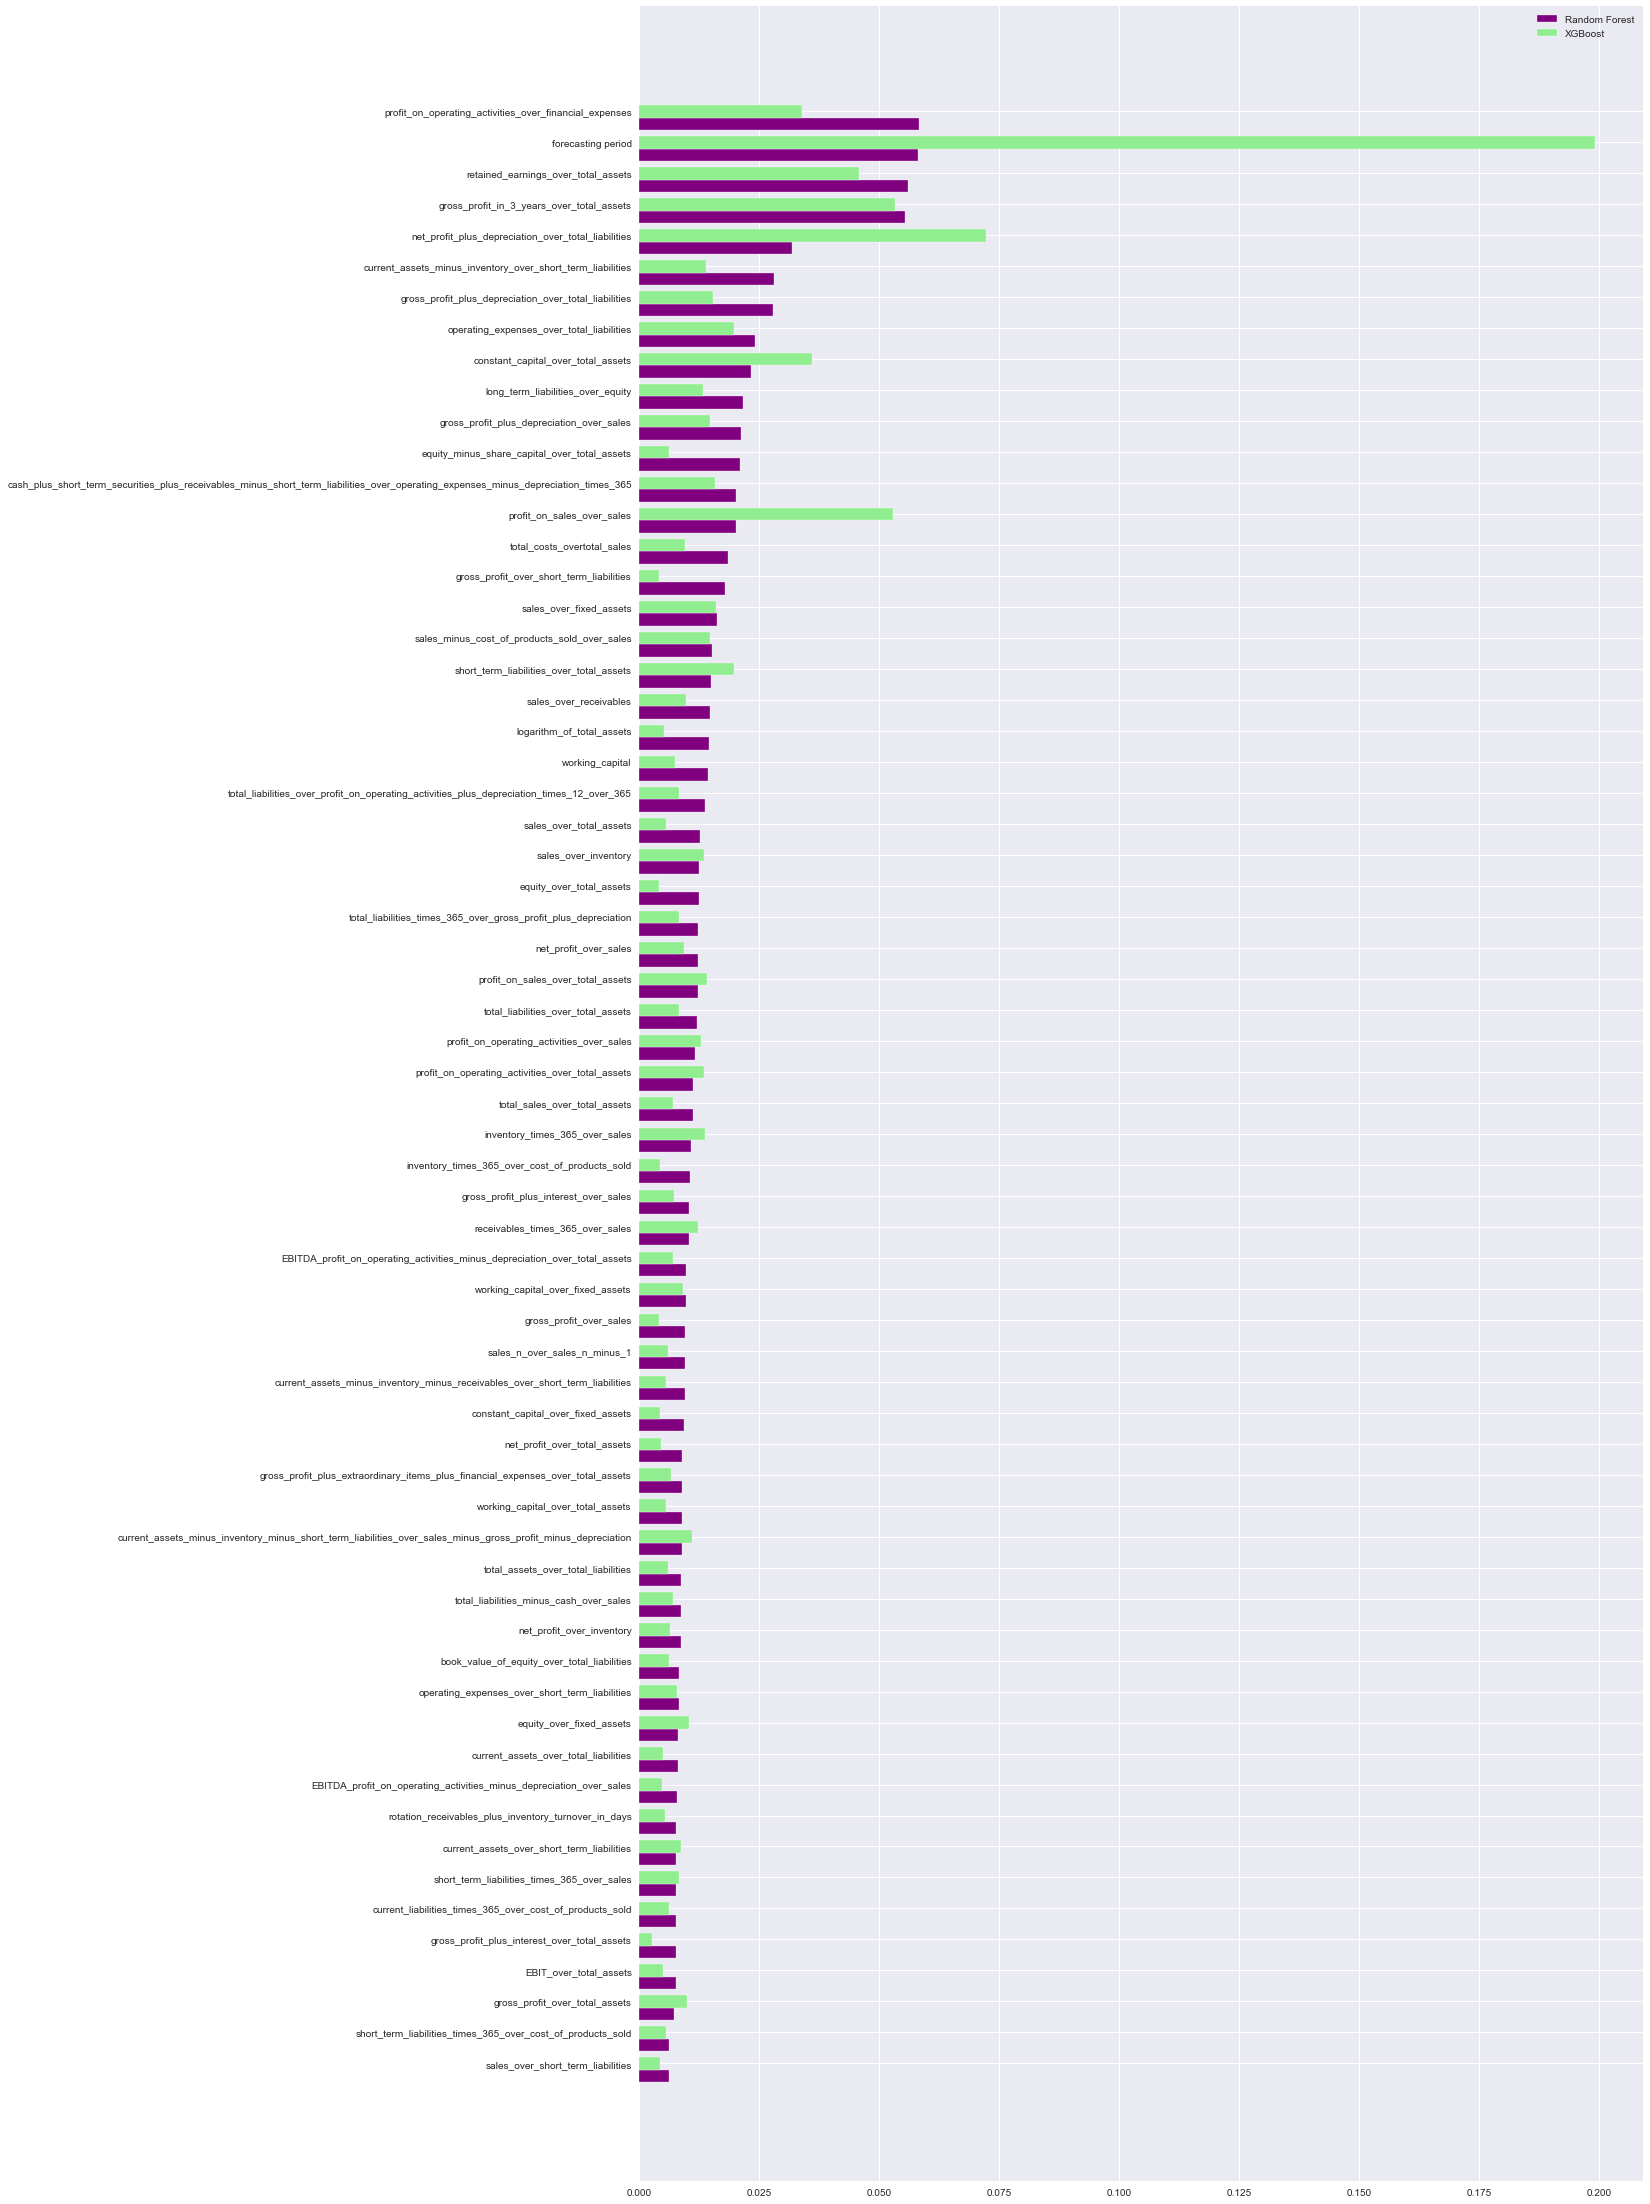

In [61]:
feature_importance=pd.DataFrame({
    'rfc':rf_t.feature_importances_,
    'xgb':xgb_model.feature_importances_},index=X.columns)
feature_importance.sort_values(by='rfc',ascending=True,inplace=True)

index = np.arange(len(feature_importance))
fig, ax = plt.subplots(figsize=(18,40))
rfc_feature=ax.barh(index,feature_importance['rfc'],0.4,color='purple',label='Random Forest')
dt_feature=ax.barh(index+0.4,feature_importance['xgb'],0.4,color='lightgreen',label='XGBoost')
ax.set(yticks=index+0.4,yticklabels=feature_importance.index)

ax.legend()
plt.show()

**In general, Random Forest and XGBoost Classifier extract similar features regarding to most important features.**

# From the graph, we can list most important factors which contribute to probability of bankruptcy in Polish Banks dataset. For example:

**Gross profit in 3 years over total assets**

**Forecasting period**

**Net profit plus depreciation over total liabilities**

**Profit on operating activities over financial expenses** 